# Prototype 01
## Experiment 03

In [2]:
executed_yet = False

In [3]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [4]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [5]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.enums import Execution, Evaluation
from src.data_provider import DataProvider
from src.functions import calculate_balance_metrics, split_training_data
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from prototypes.prototype_01.environment import Environment
from prototypes.prototype_01.deep_q_network import DeepQNetwork
from prototypes.prototype_01.agent import Agent
from prototypes.prototype_01.client import Client

from prototypes.prototype_01.server import Server
from prototypes.prototype_02.experiment import Experiment

In [7]:
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

## --- Hyperparameters ---

In [8]:
import torch.nn as nn
import torch

def run_sample_distribution_experiment(experiment_id, experiment_version, nr_clients, training_data_strides, sampling_probabilities_01, sampling_probabilities_02):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = nr_clients
    NR_ROUNDS = 30
    NR_EPISODES_PER_ROUND = 100
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 64
    N_HIDDEN_3 = 32
    N_FEATURES = rl_training_data_dict[Behavior.NORMAL].shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01

    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    EPSILON_END = 0.01

    calculate_balance_metrics(sampling_probabilities_01, sampling_probabilities_02, NR_EPISODES_PER_CLIENT)

    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

    clients = []
    for i in range(NR_CLIENTS):
        entity_id = i + 1
        if entity_id % 2 == 0:
            SAMPLING_PROBABILITIES = sampling_probabilities_01
        else:
            SAMPLING_PROBABILITIES = sampling_probabilities_02
            
        environment = Environment(entity_id, training_data_strides[i], sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
        agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
        server.add_client(client)


    evaluations = [Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
    #server.run_federation(evaluations=evaluations, evaluation_frequency=1)
    experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)
    return experiment

In [9]:
def show_learning_curves(experiment):
    experiment.server.plot_learning_curves()

In [10]:
def show_experiment_graphs(experiment):
    experiment.plot_behavior_performances()
    experiment.plot_test_performances()
    experiment.plot_class_weighted_test_accuracy()

---
## Data Preparation

In [11]:
rl_training_data_dict, rl_test_data_dict, _ = DataProvider.get_scaled_train_test_split_one(split=0.8, scaling_minmax=True, scale_normal_only=True)

training_data_strides = split_training_data(rl_training_data_dict, 10)

---
## Scenario 00 (Baseline)
1 Client trained with unit sampling probabilities

In [11]:
e1v0 = run_sample_distribution_experiment(1, 0, 1, training_data_strides, unit_sampling_probabilities, unit_sampling_probabilities)

Dataset Balance Metrics: MID=0.0 & WCS=1.0
=== STARTING EXPERIMENT 1.0 ===

Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       2.36 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      98.85 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      87.95 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |     100    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      50.7  | MTDTechnique.CNC_IP_SHUFFLE           |           852 |

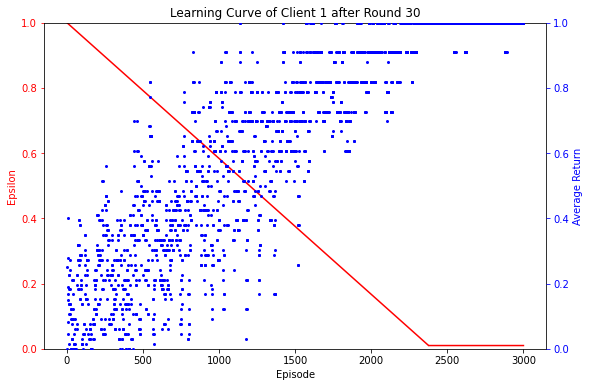

In [12]:
show_learning_curves(e1v0)

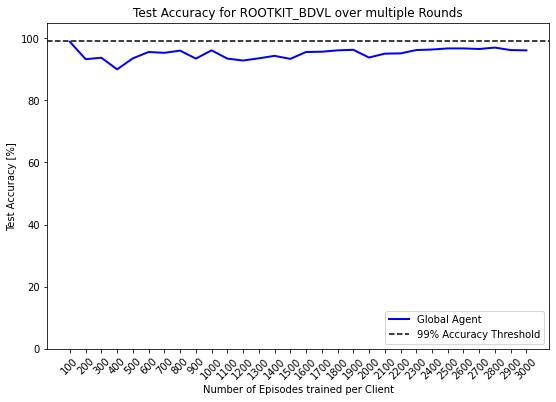

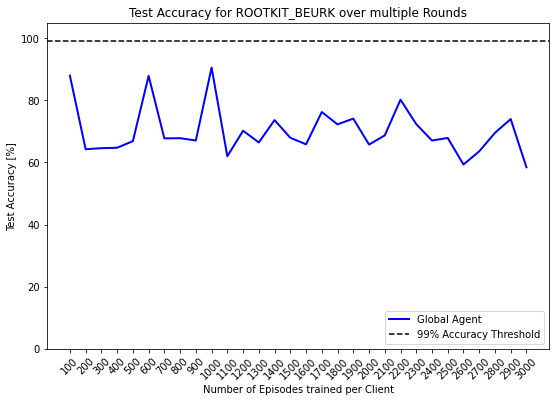

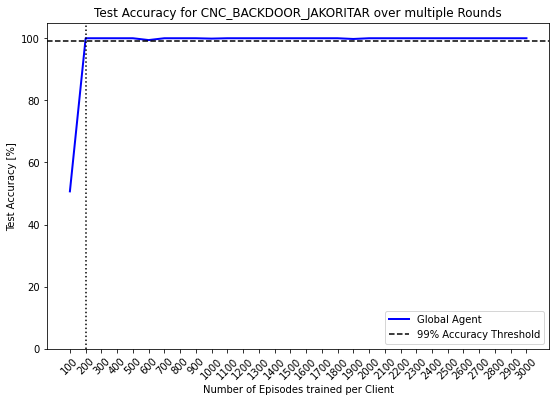

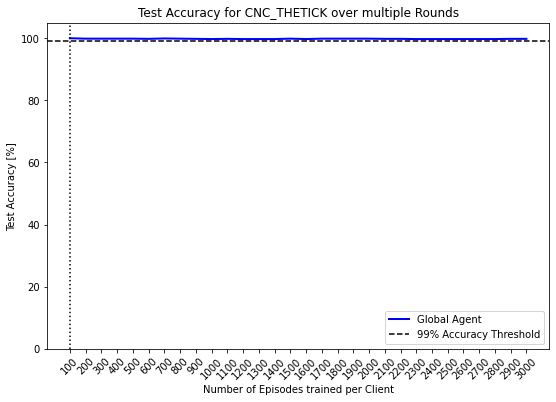

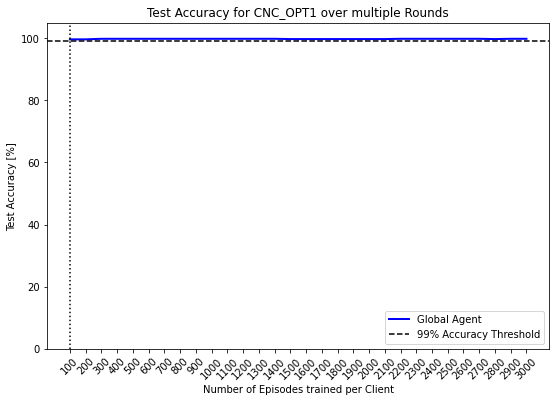

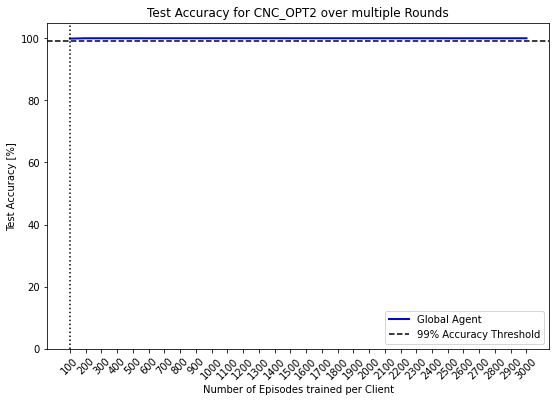

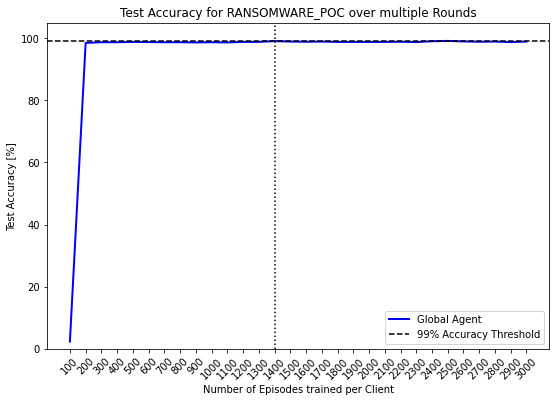

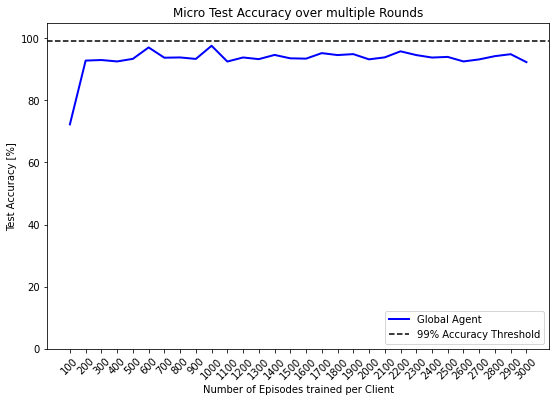

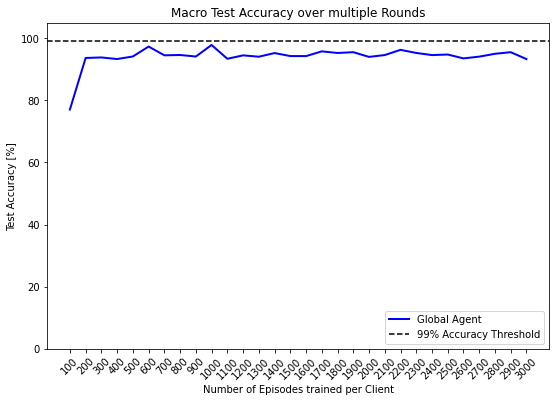

In [13]:
show_experiment_graphs(e1v0)

---
## Scenario 01 (Globally and Locally Class Balanced)

In [14]:
e1v1 = run_sample_distribution_experiment(1, 1, 10, training_data_strides, unit_sampling_probabilities, unit_sampling_probabilities)

Dataset Balance Metrics: MID=0.0 & WCS=1.0
=== STARTING EXPERIMENT 1.1 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       1.02 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.03 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      87.54 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.8  | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      86.85 | MTDTechnique.CNC_IP_SHUFFLE           |           852 

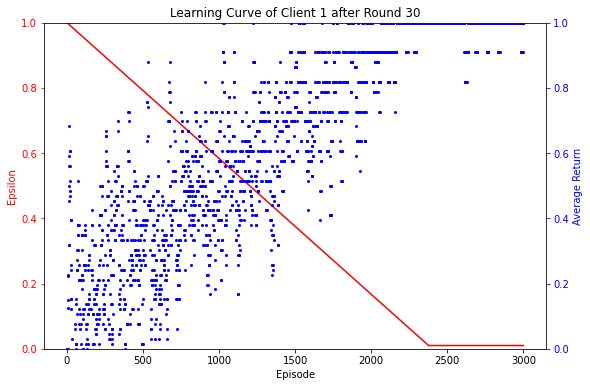

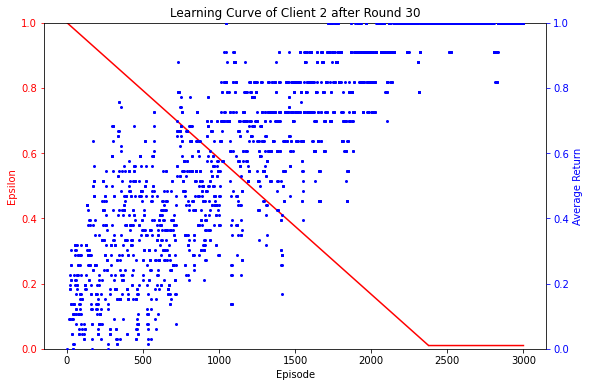

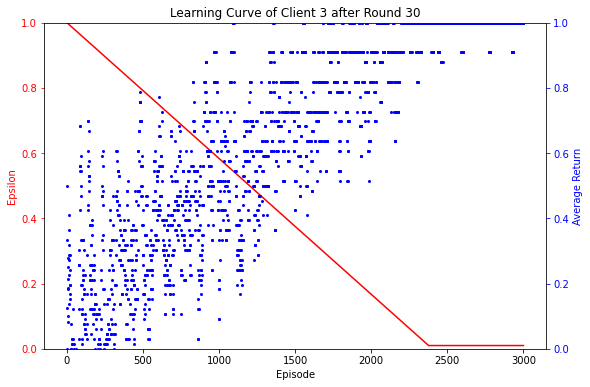

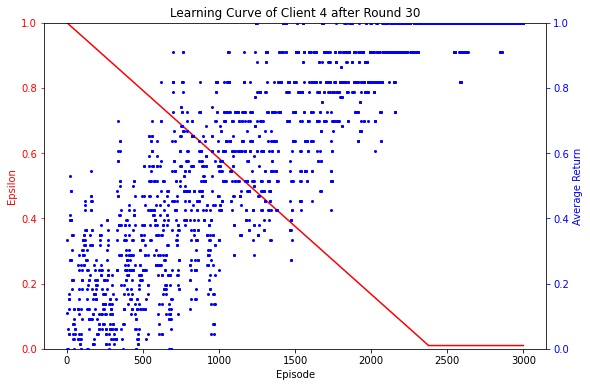

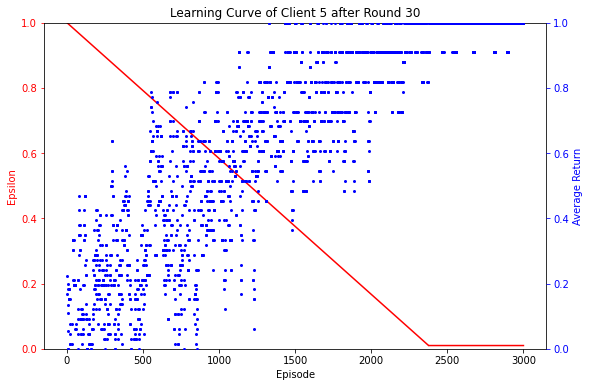

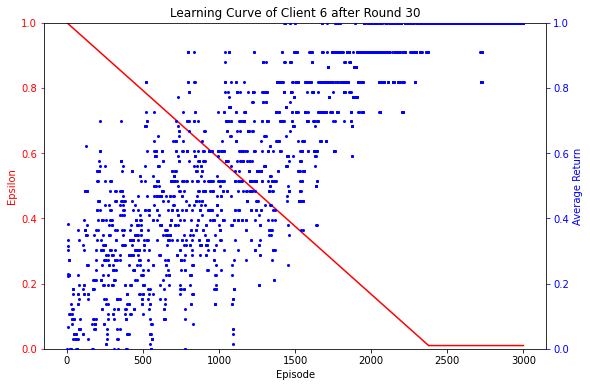

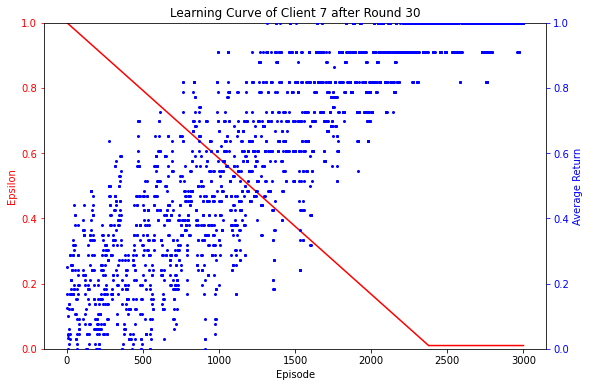

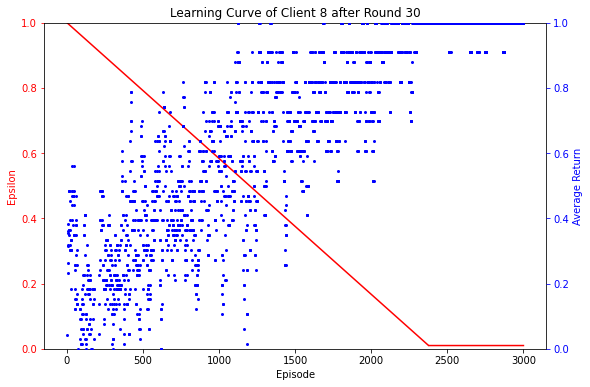

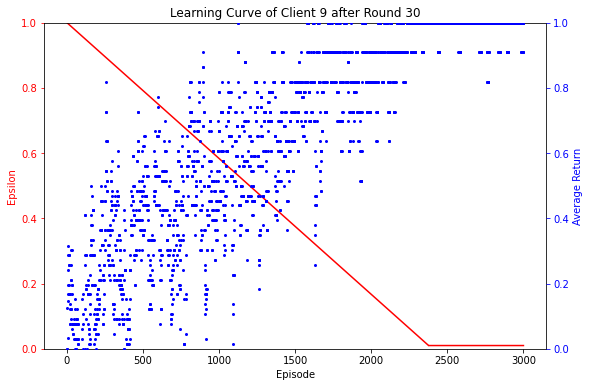

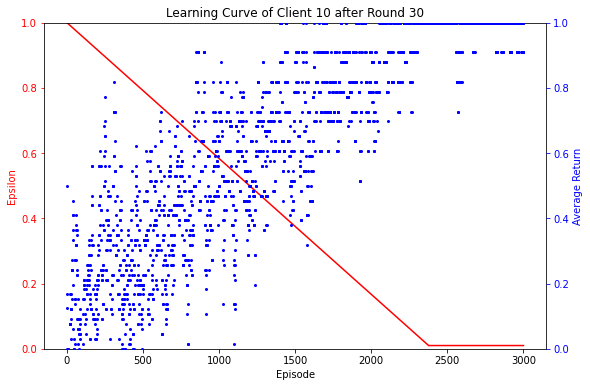

In [15]:
show_learning_curves(e1v1)

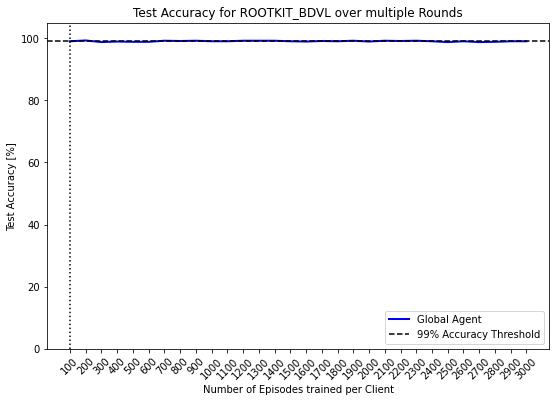

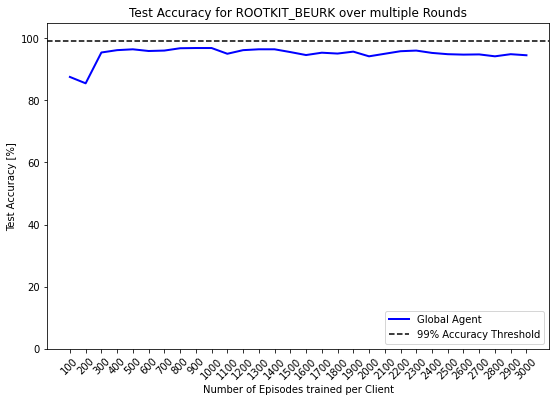

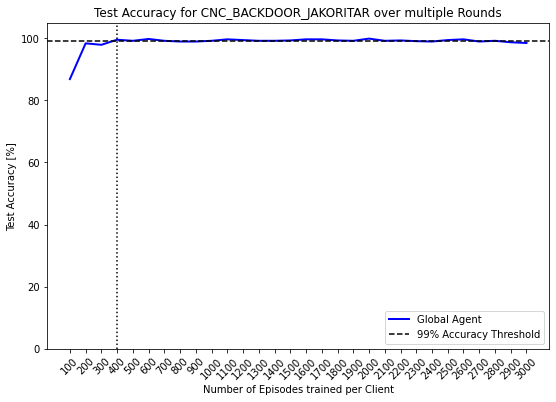

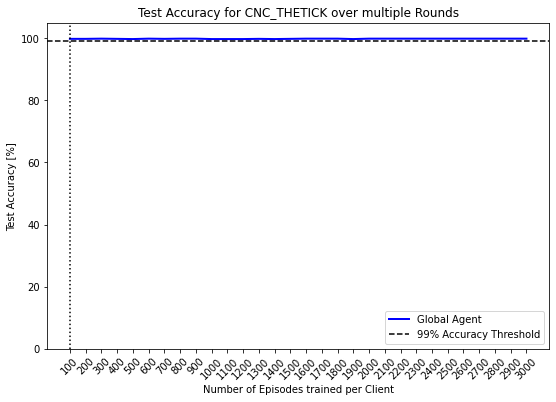

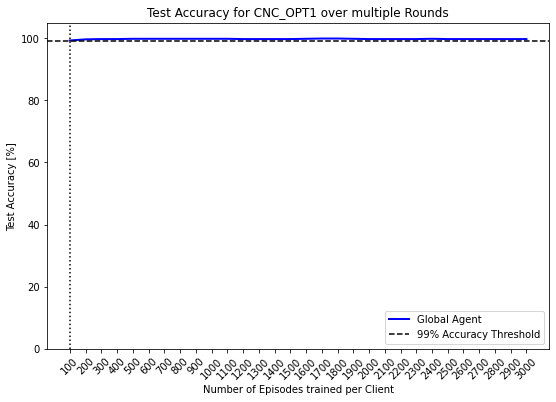

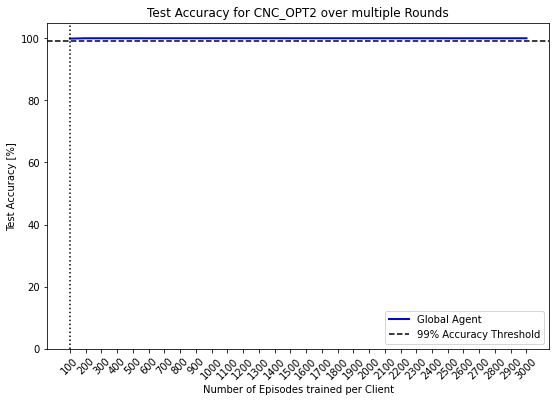

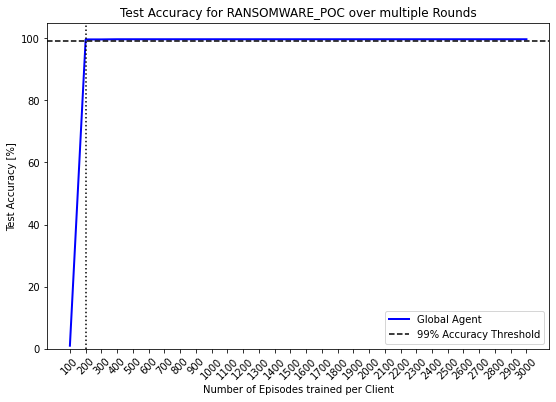

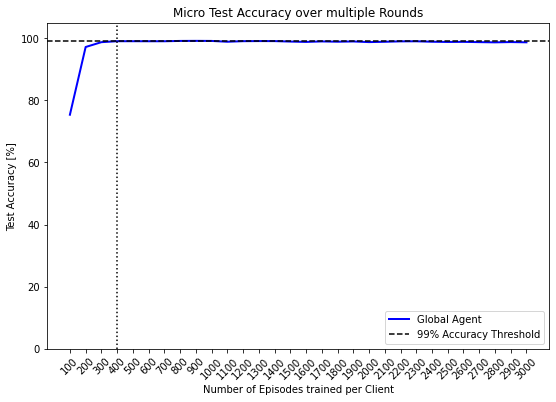

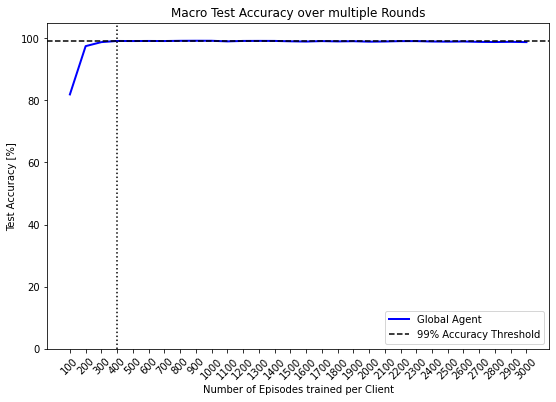

In [16]:
show_experiment_graphs(e1v1)

---
## Scenario 02 (Globally Imbalanced and Locally Class Balanced)

In [17]:
e1v2 = run_sample_distribution_experiment(1, 2, 10, training_data_strides, regular_sampling_probabilities, regular_sampling_probabilities)

Dataset Balance Metrics: MID=0.0267 & WCS=1.0
=== STARTING EXPERIMENT 1.2 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |      99.68 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.2  | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      95.07 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.8  | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      10.68 | MTDTechnique.CNC_IP_SHUFFLE           |           8

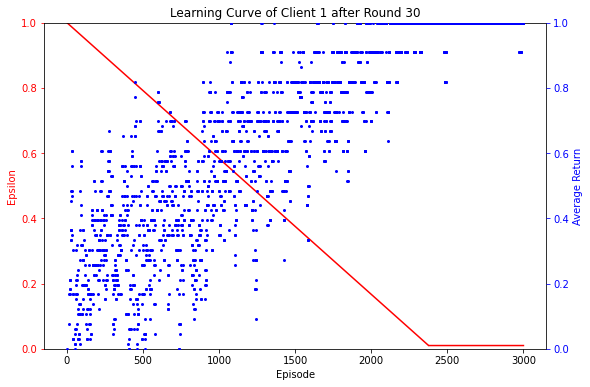

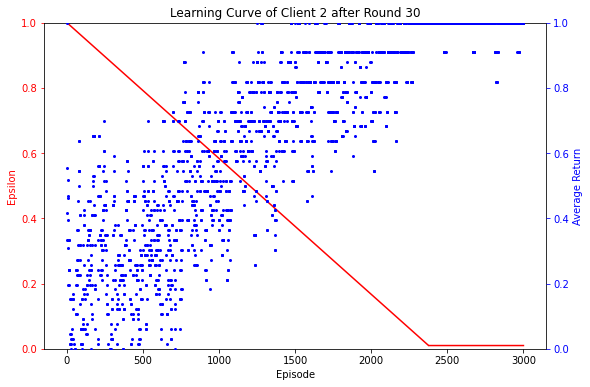

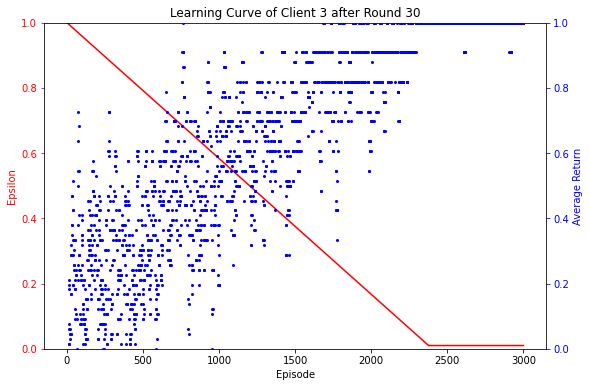

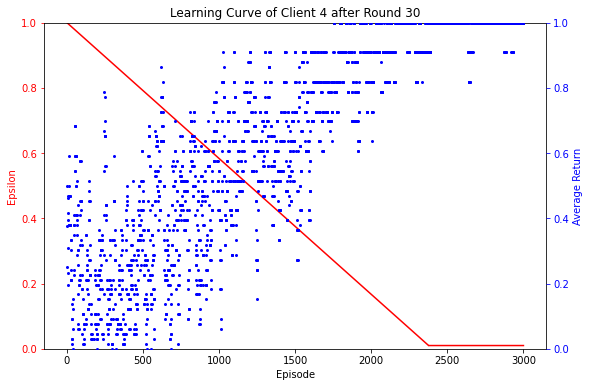

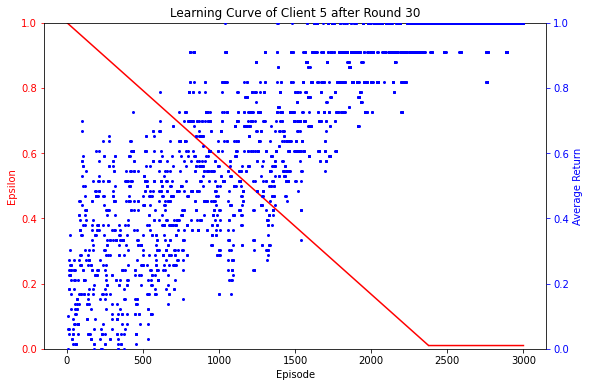

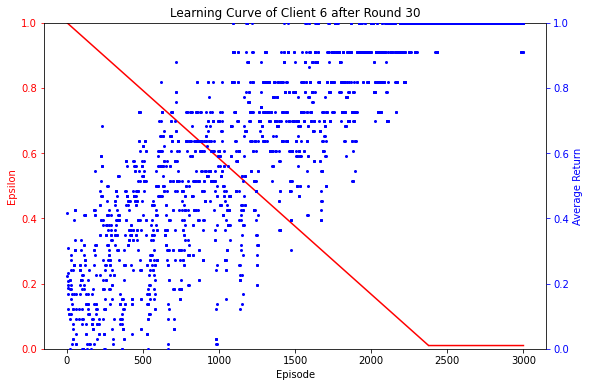

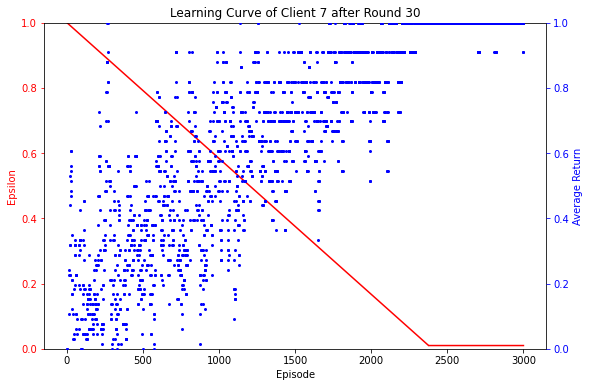

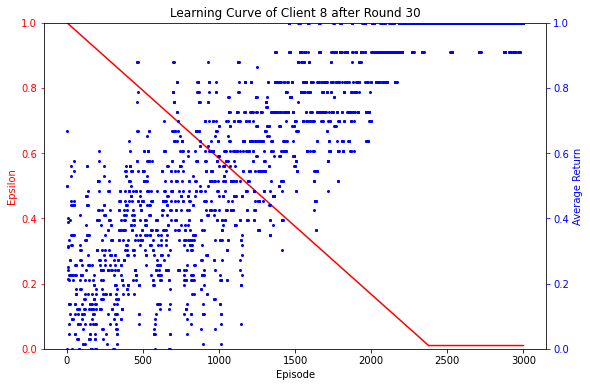

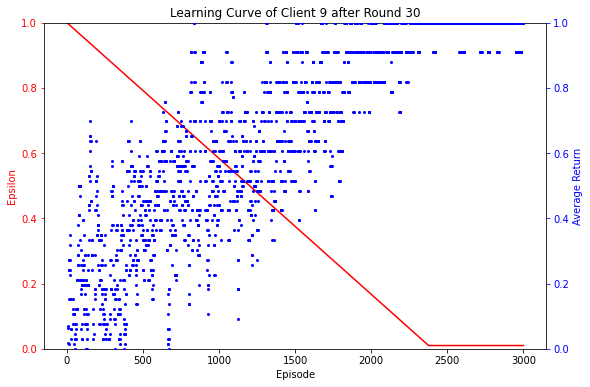

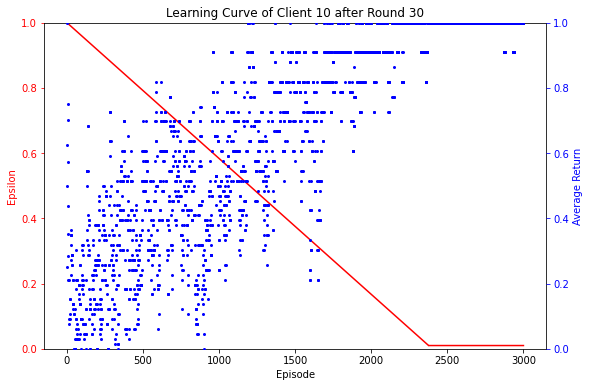

In [18]:
show_learning_curves(e1v2)

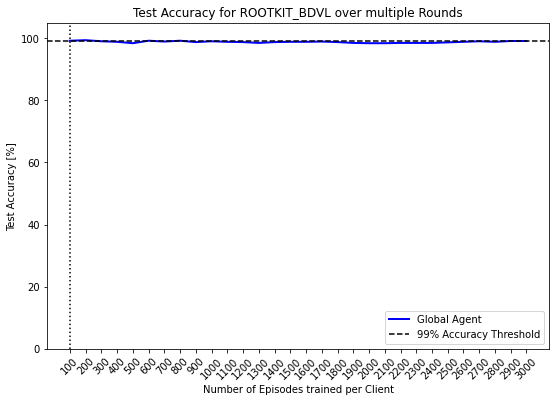

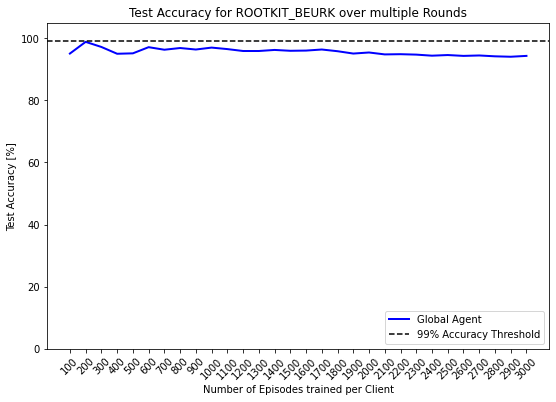

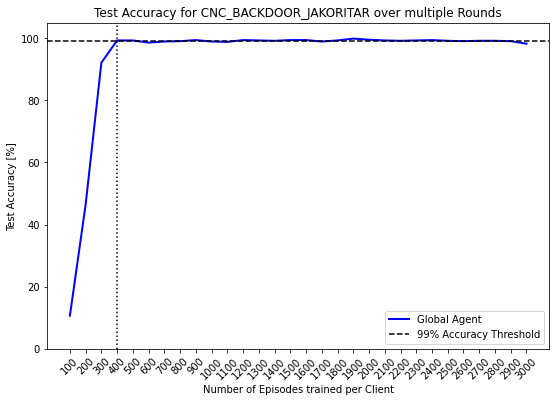

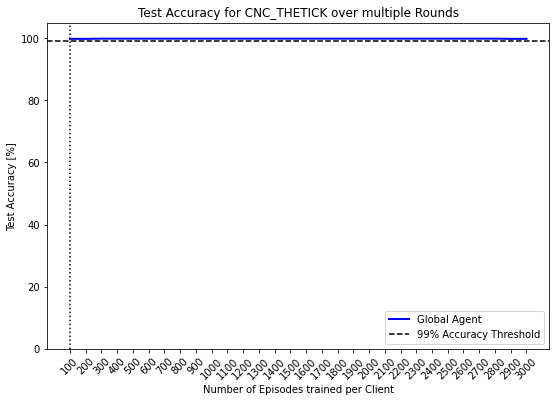

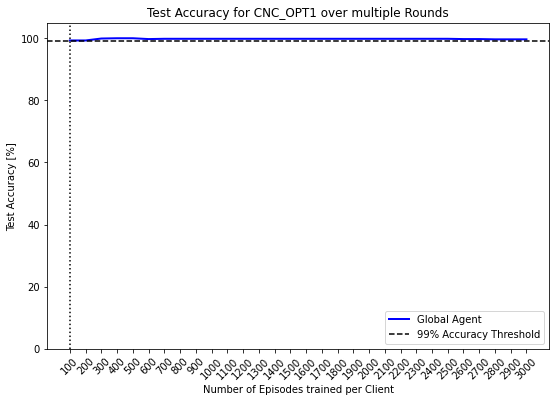

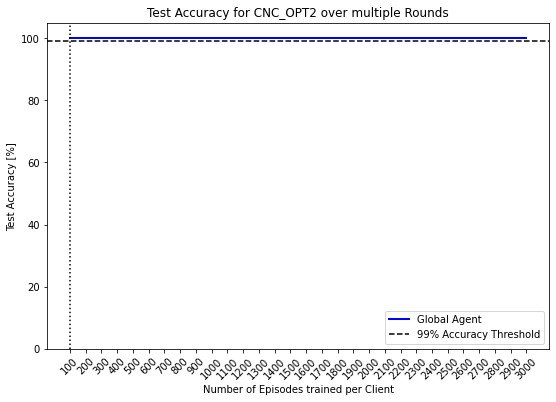

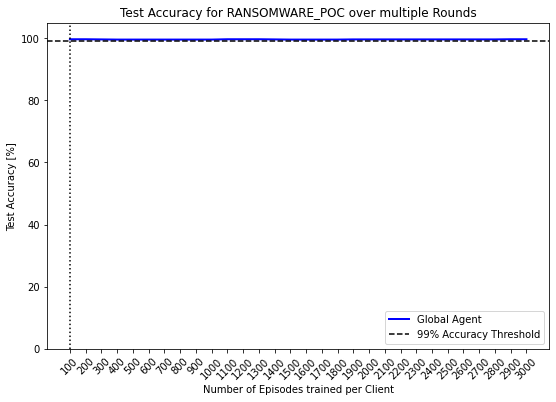

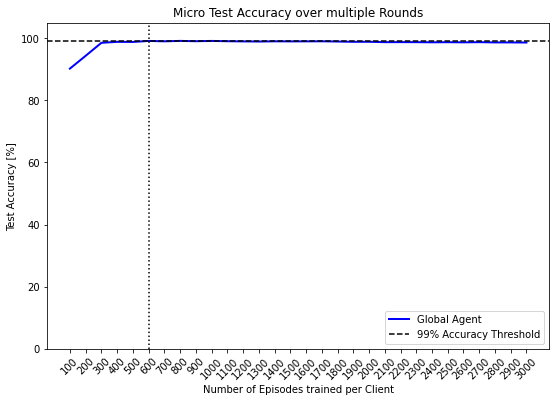

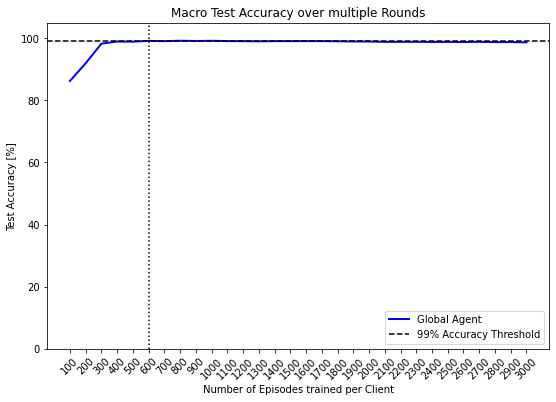

In [19]:
show_experiment_graphs(e1v2)

---
## Scenario 03 (Globally Balanced but Locally Class Imbalanced)

In [20]:
e1v3 = run_sample_distribution_experiment(1, 3, 10, training_data_strides, regular_sampling_probabilities, inverted_sampling_probabilities)

Dataset Balance Metrics: MID=0.0 & WCS=0.9516
=== STARTING EXPERIMENT 1.3 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       0.8  | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      98.94 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      72.55 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.87 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      96.71 | MTDTechnique.CNC_IP_SHUFFLE           |           8

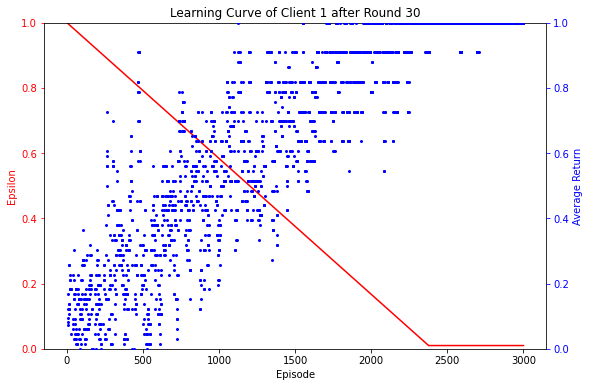

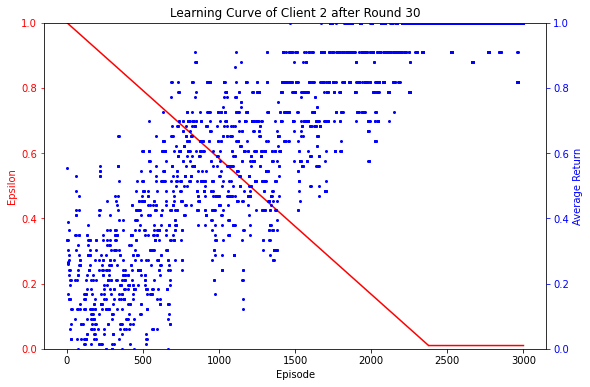

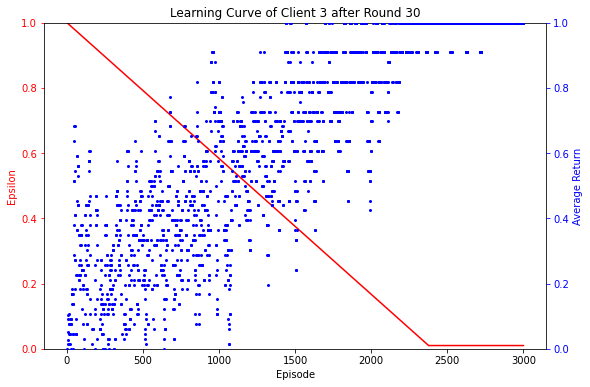

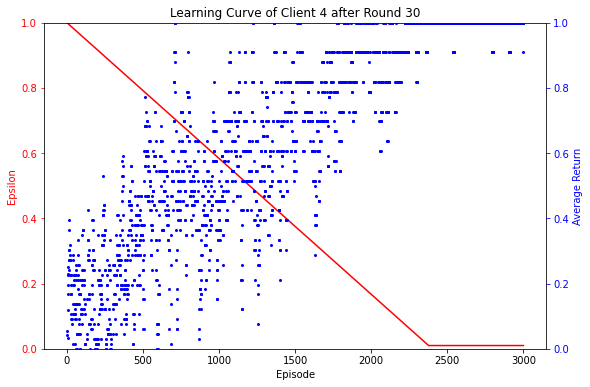

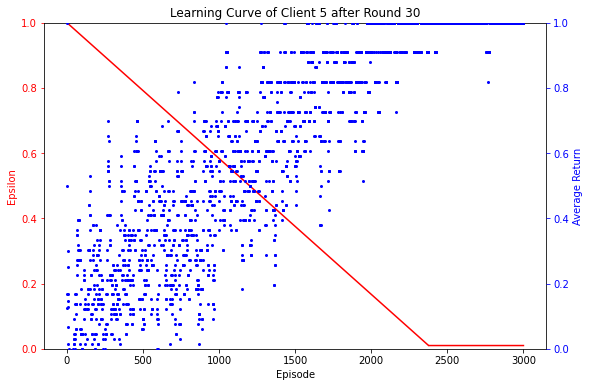

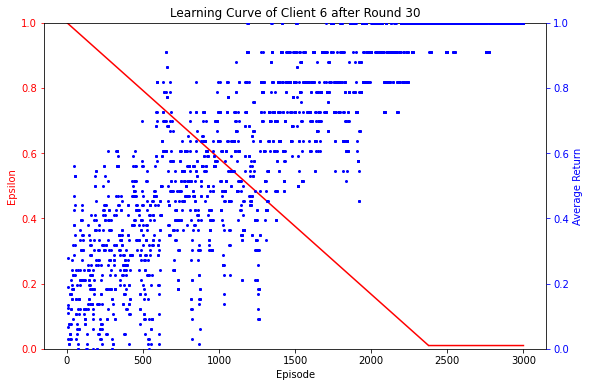

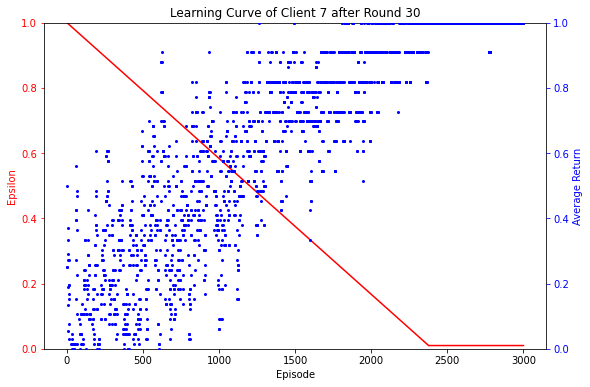

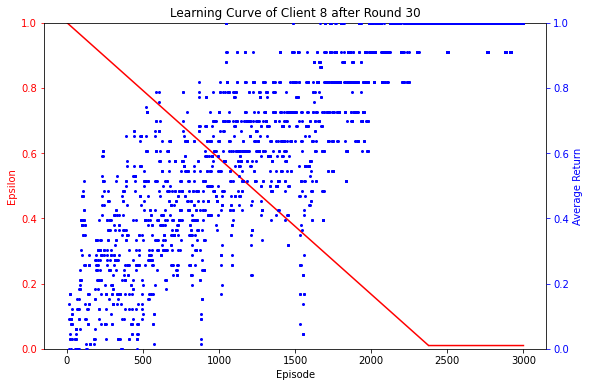

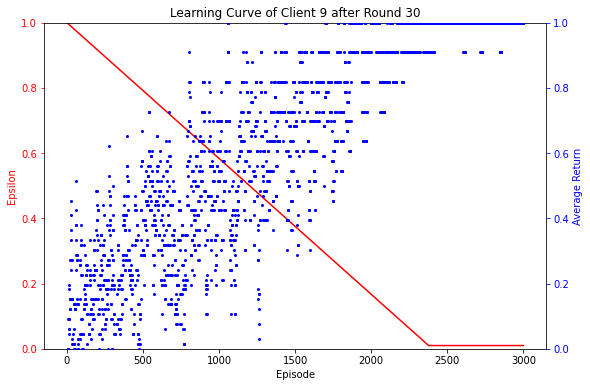

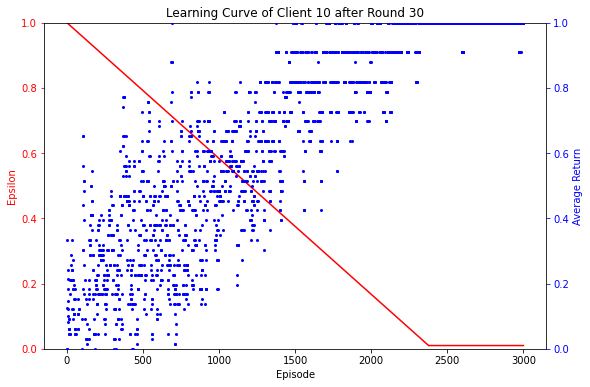

In [21]:
show_learning_curves(e1v3)

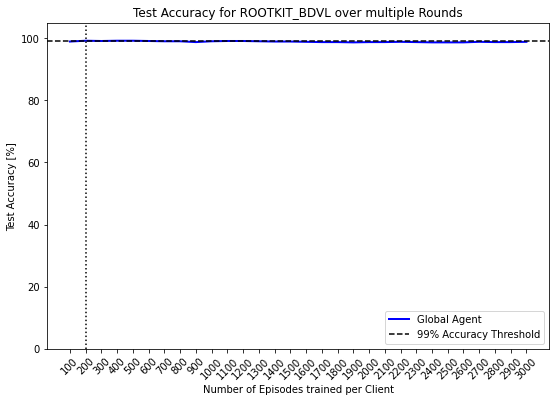

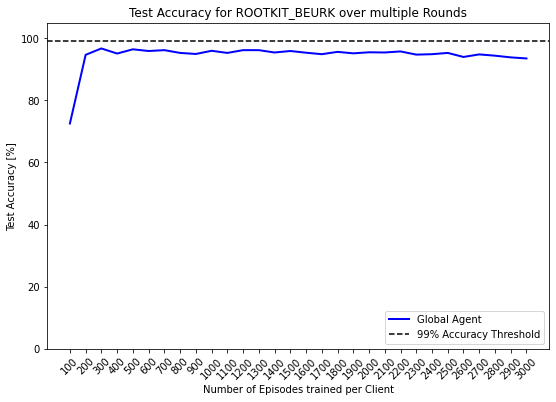

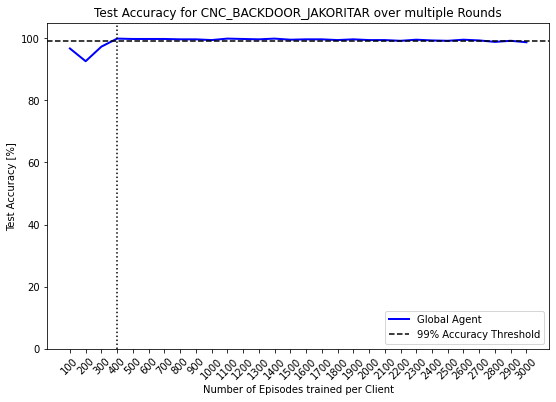

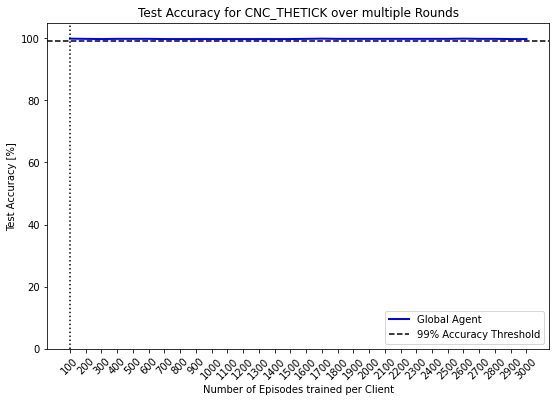

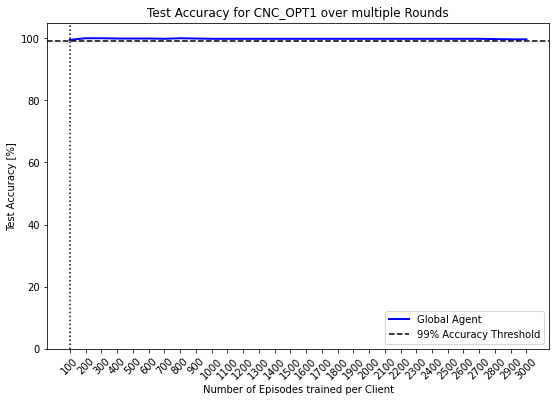

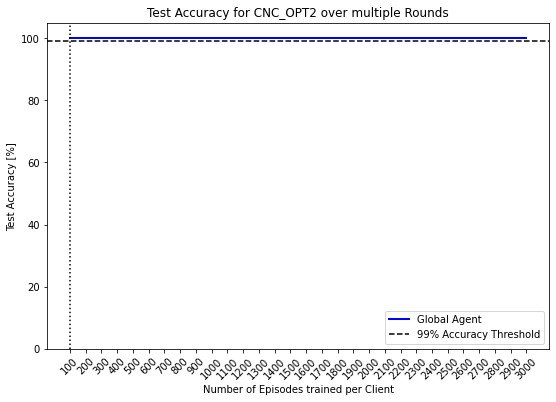

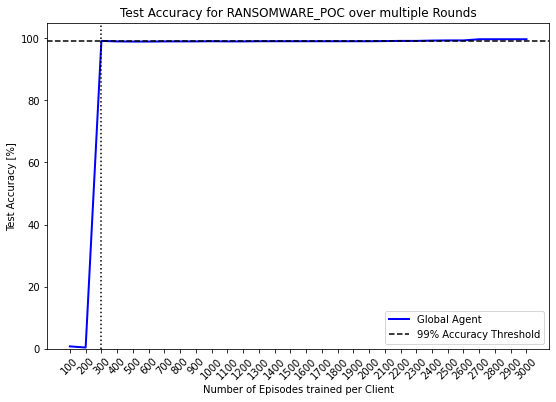

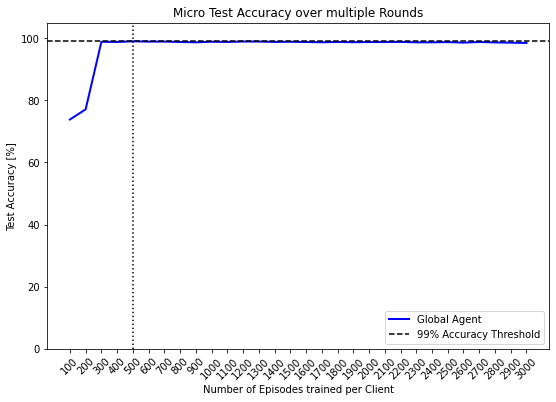

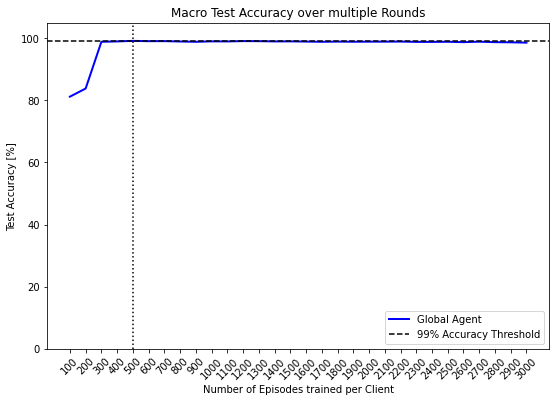

In [22]:
show_experiment_graphs(e1v3)

---
## Scenario 04 (Globally and Locally Class Imbalanced)

In [23]:
e1v4 = run_sample_distribution_experiment(1, 4, 10, training_data_strides, unit_sampling_probabilities, regular_sampling_probabilities)

Dataset Balance Metrics: MID=0.0066 & WCS=0.9878
=== STARTING EXPERIMENT 1.4 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.29 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      96.3  | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.87 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      19.6  | MTDTechnique.CNC_IP_SHUFFLE           |         

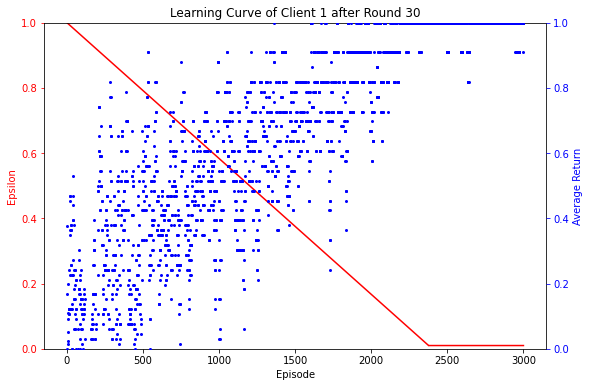

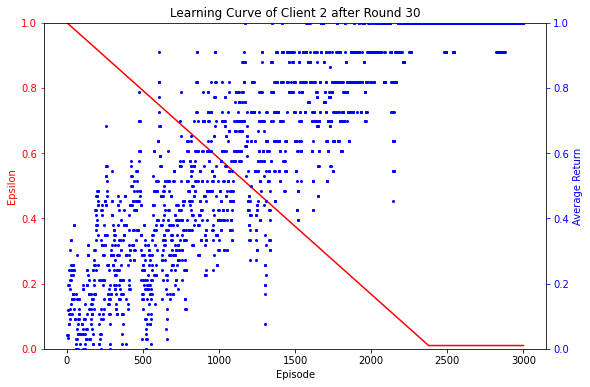

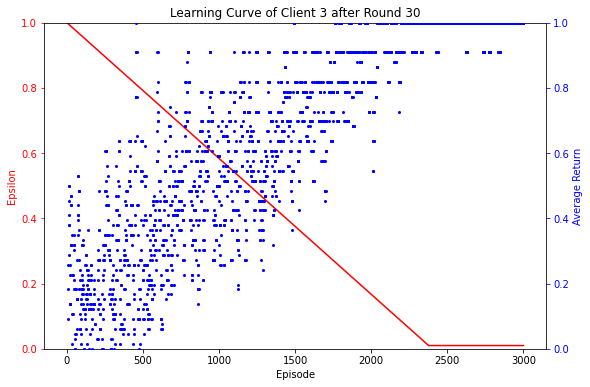

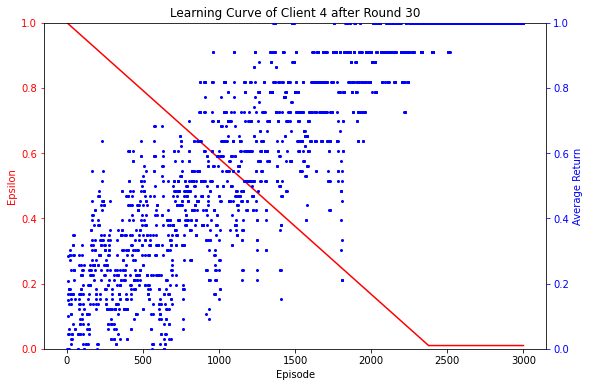

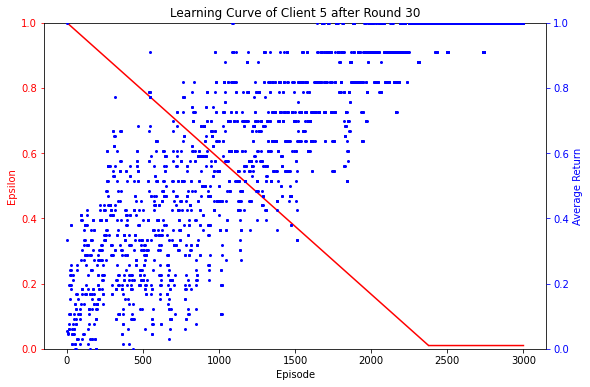

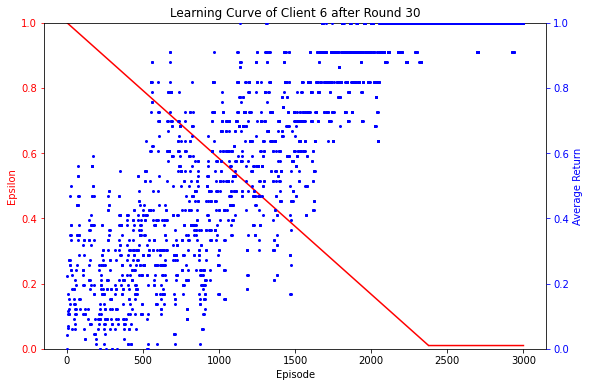

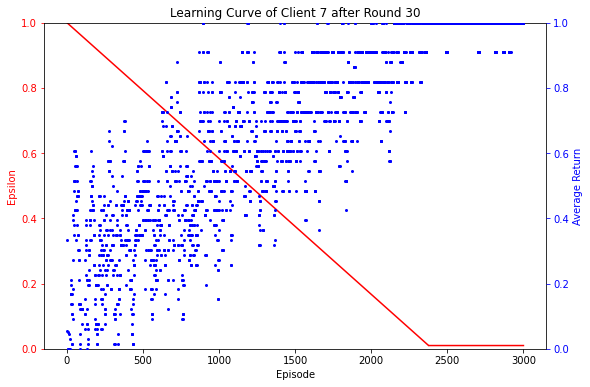

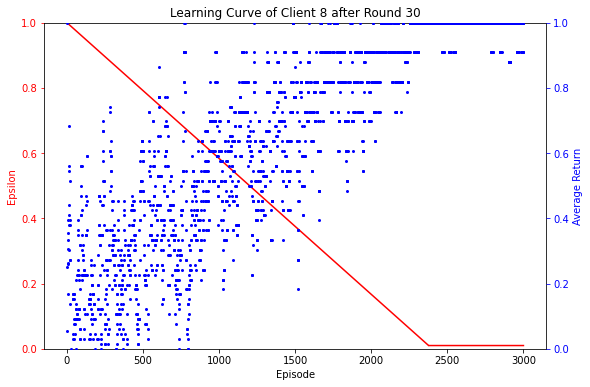

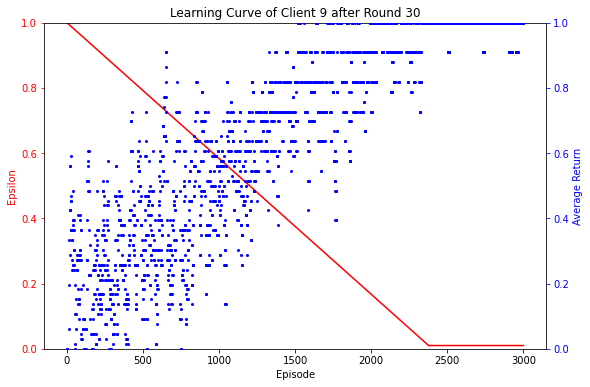

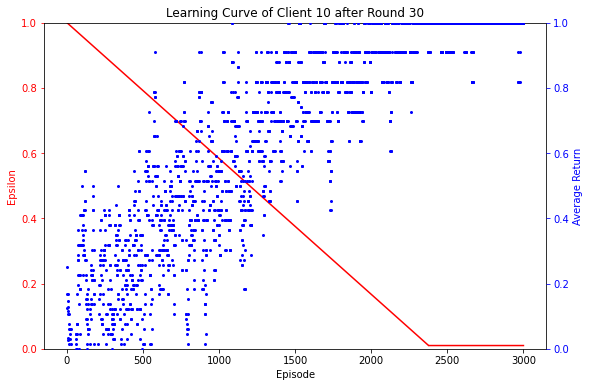

In [24]:
show_learning_curves(e1v4)

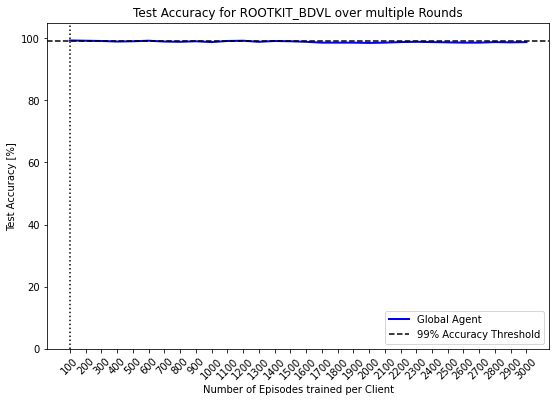

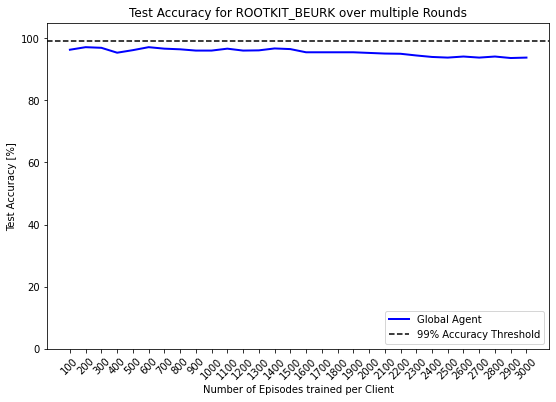

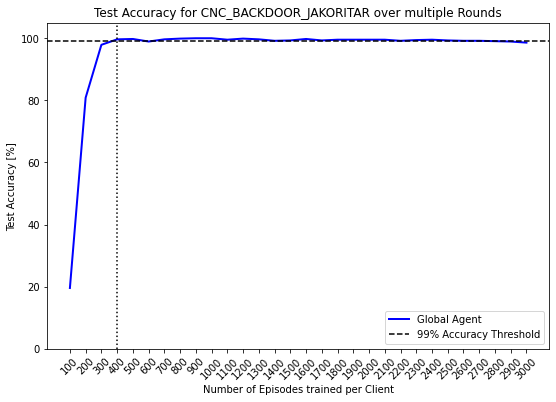

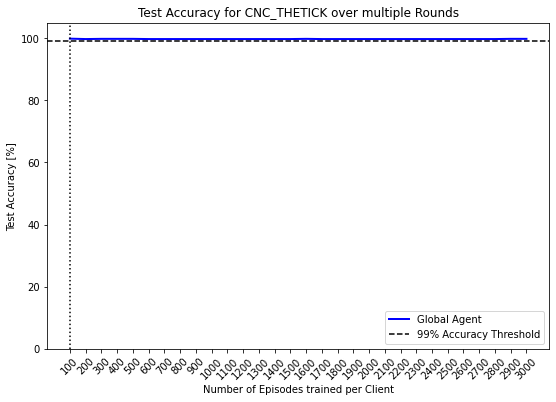

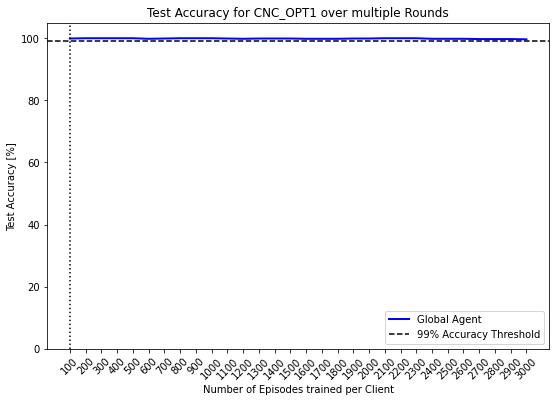

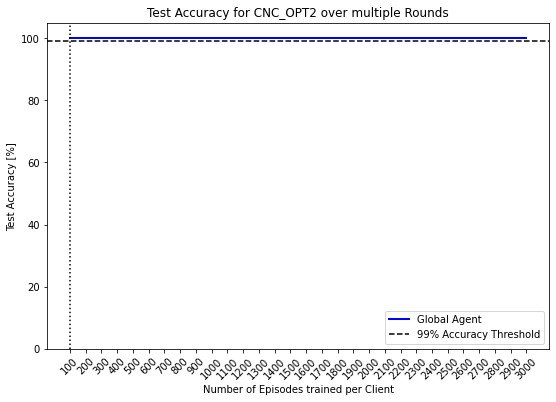

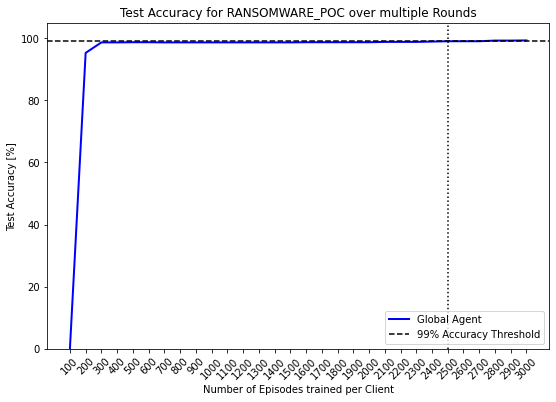

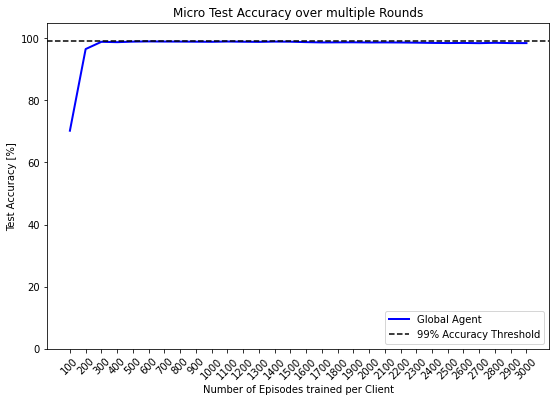

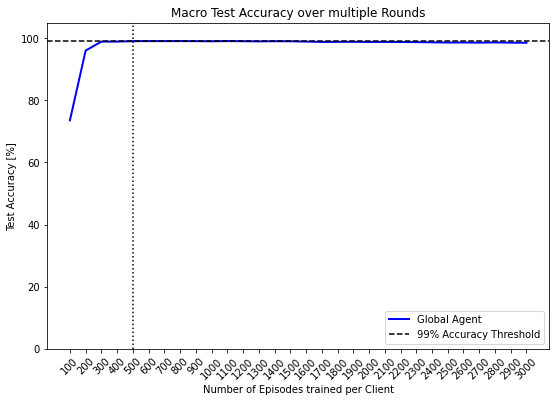

In [25]:
show_experiment_graphs(e1v4)

---
## Scenario 05 (Weak Client Exclusive Class Setting)

In [26]:
e1v5 = run_sample_distribution_experiment(1, 5, 10, training_data_strides, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02)

Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
=== STARTING EXPERIMENT 1.5 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       2.36 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.73 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      97.88 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.8  | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      37.44 | MTDTechnique.CNC_IP_SHUFFLE           |         

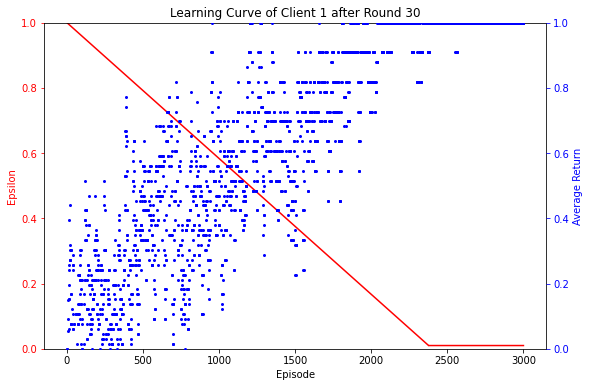

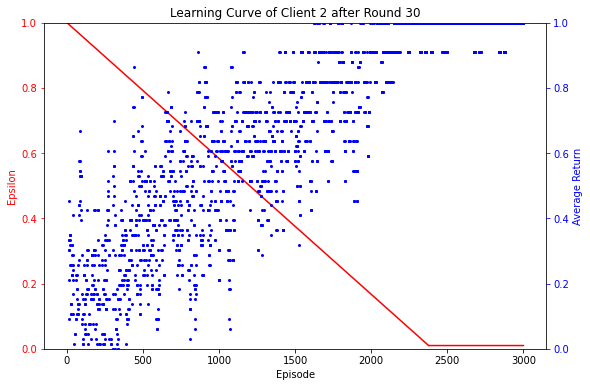

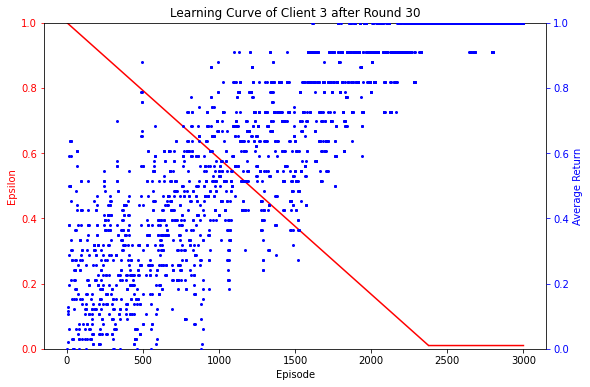

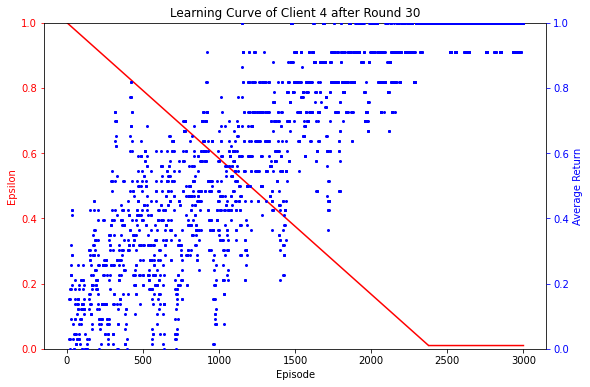

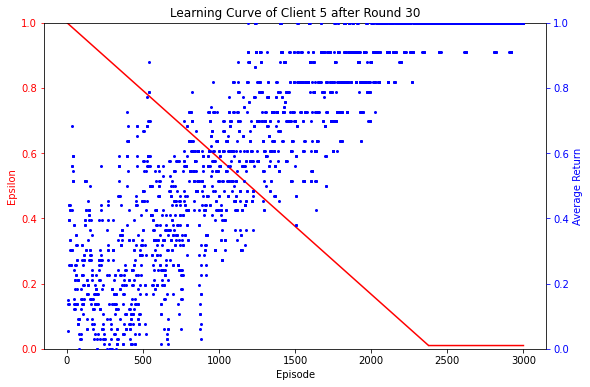

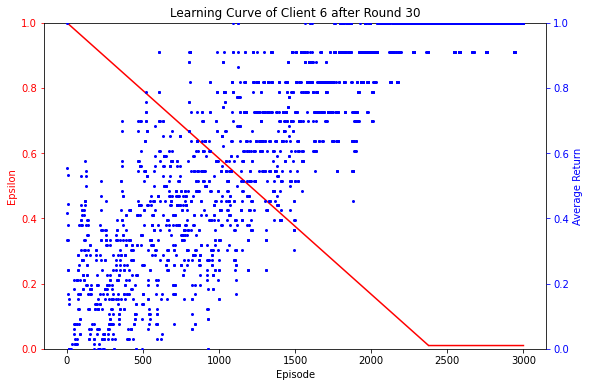

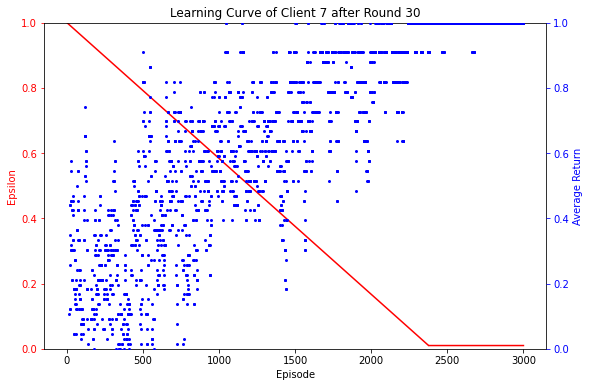

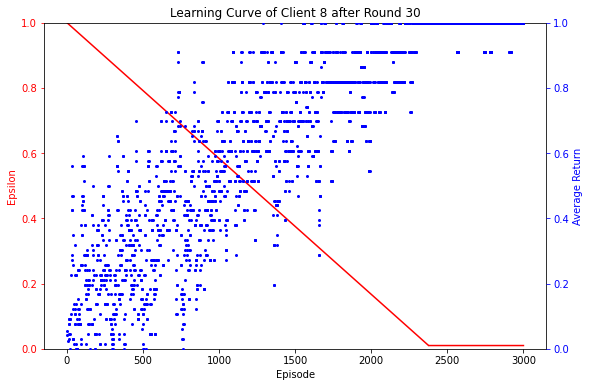

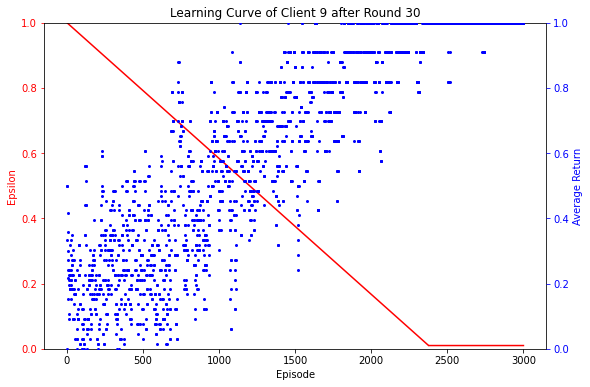

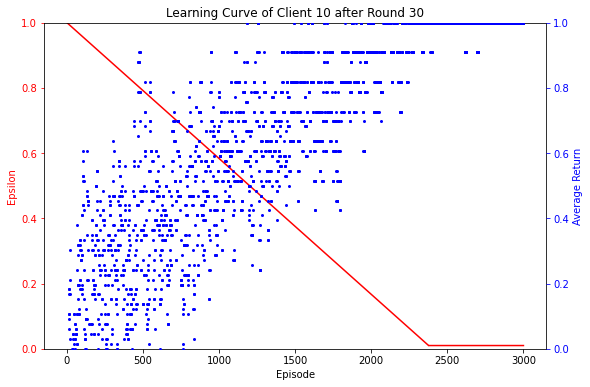

In [27]:
show_learning_curves(e1v5)

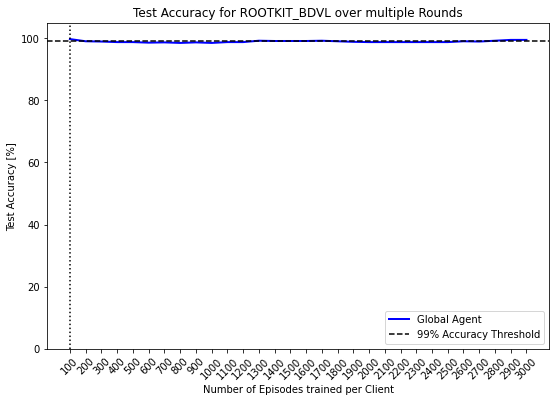

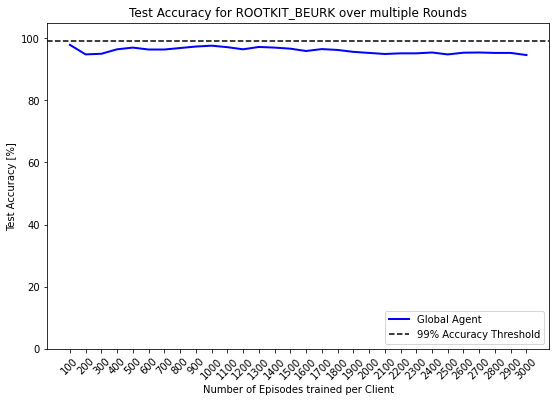

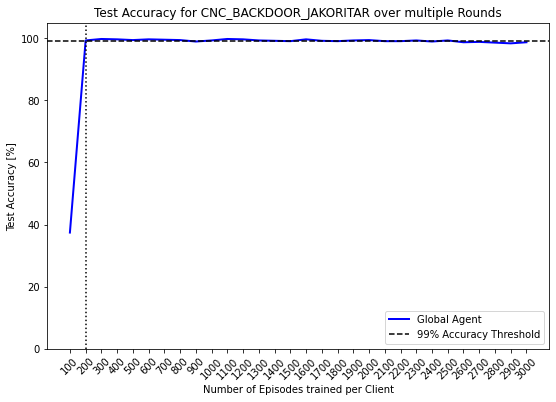

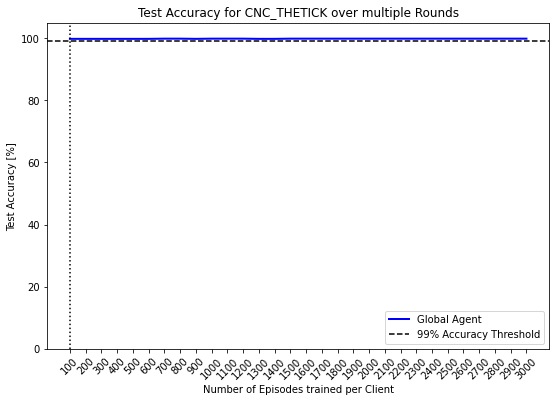

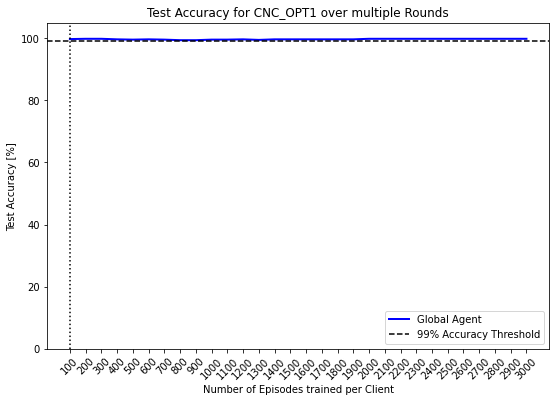

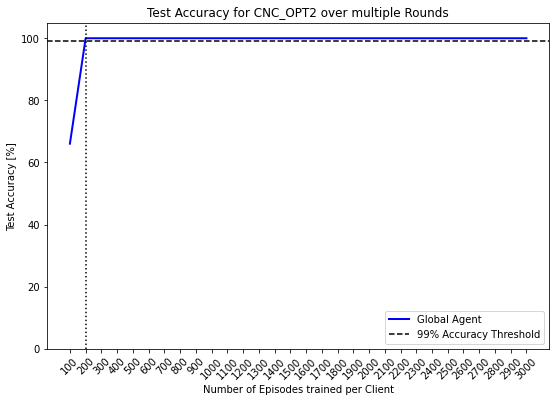

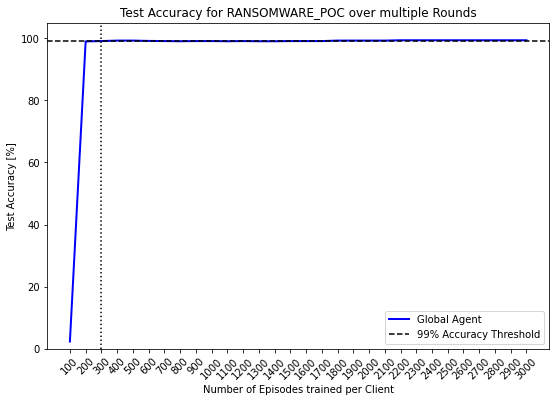

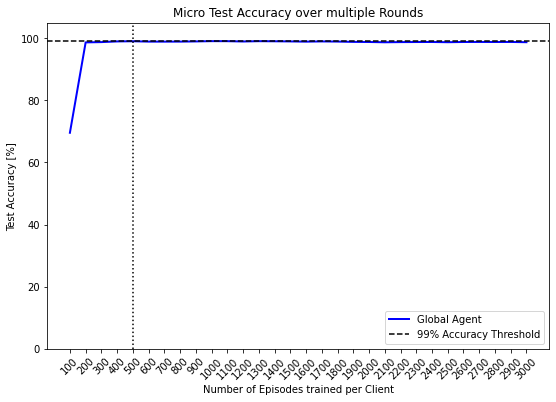

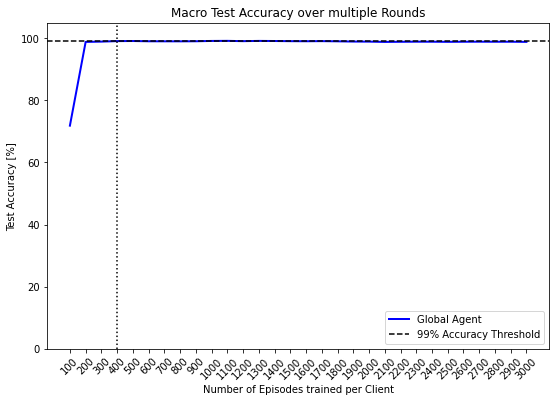

In [28]:
show_experiment_graphs(e1v5)

--- 
## Scenario 06 (Medium Client Exclusive Class Setting)

In [30]:
e1v6 = run_sample_distribution_experiment(1, 6, 10, training_data_strides, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02)

Dataset Balance Metrics: MID=0.0304 & WCS=0.8944
=== STARTING EXPERIMENT 1.6 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.56 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      99.45 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |     100    | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |       2.58 | MTDTechnique.CNC_IP_SHUFFLE           |         

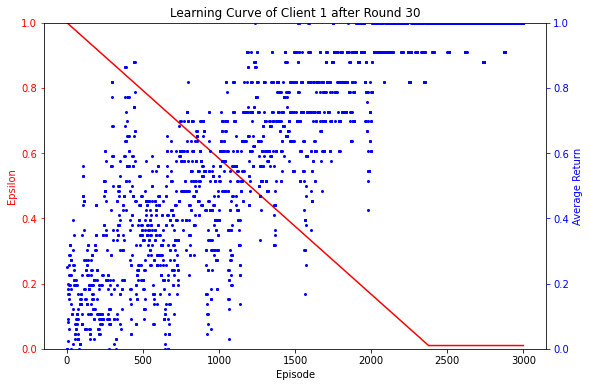

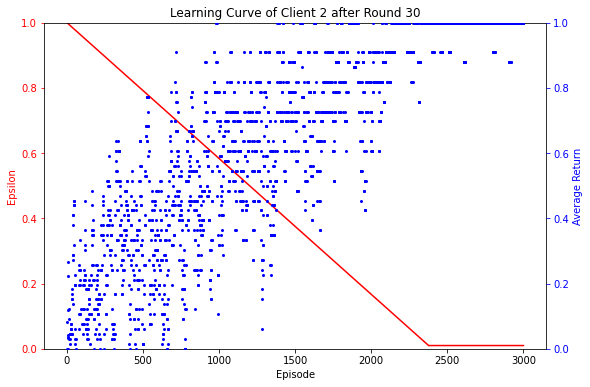

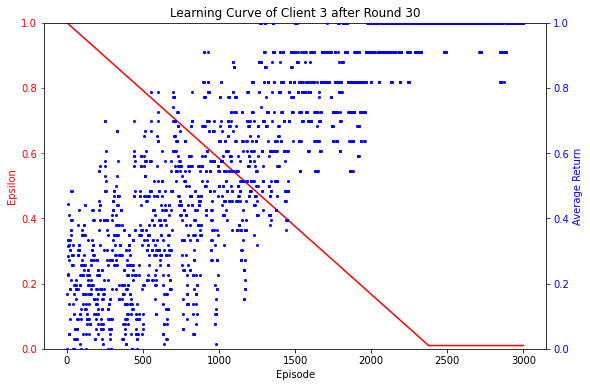

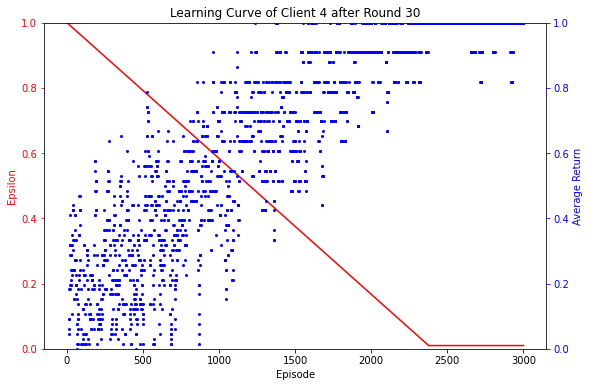

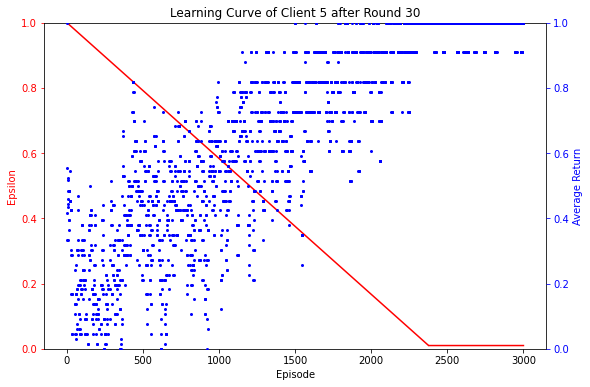

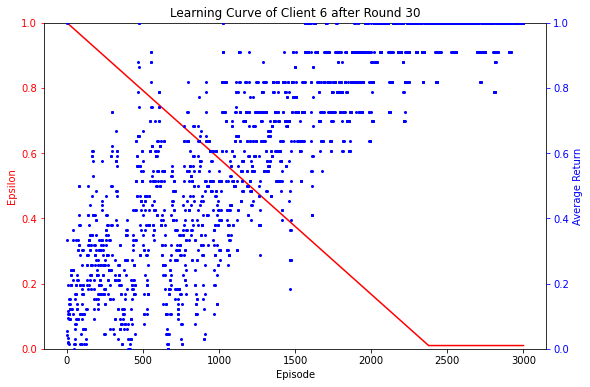

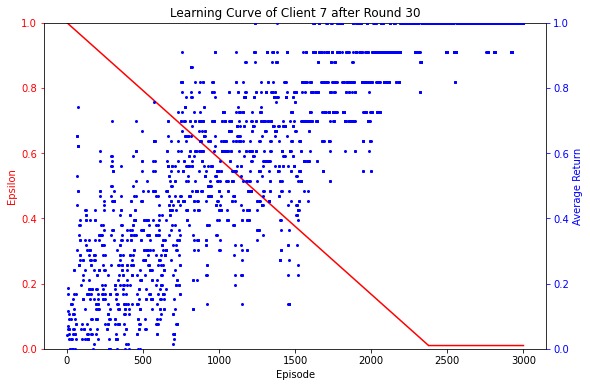

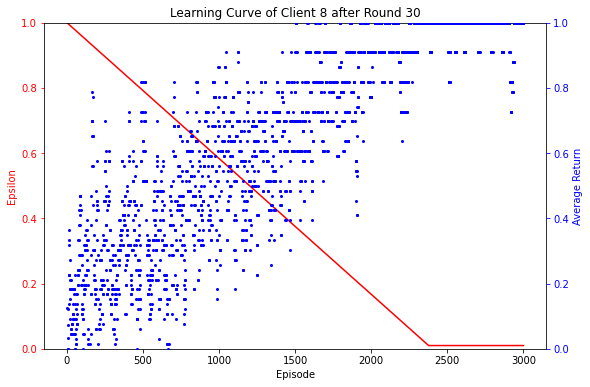

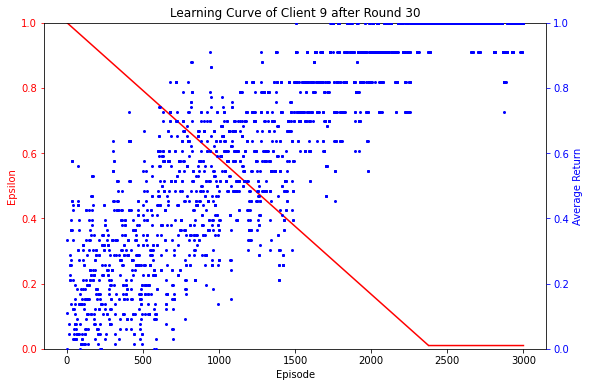

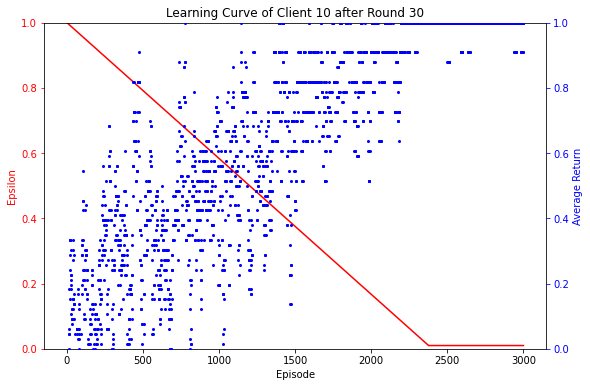

In [31]:
show_learning_curves(e1v6)

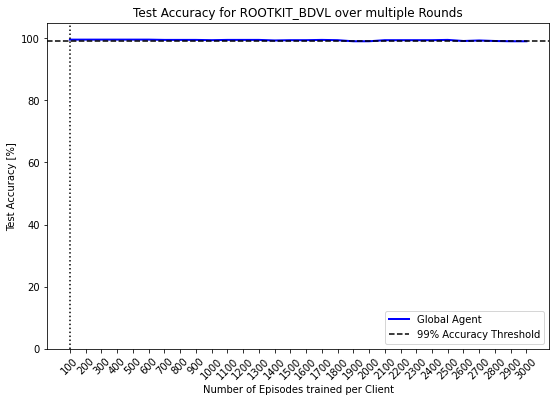

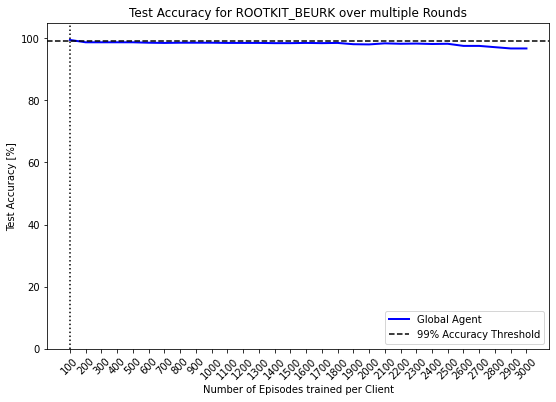

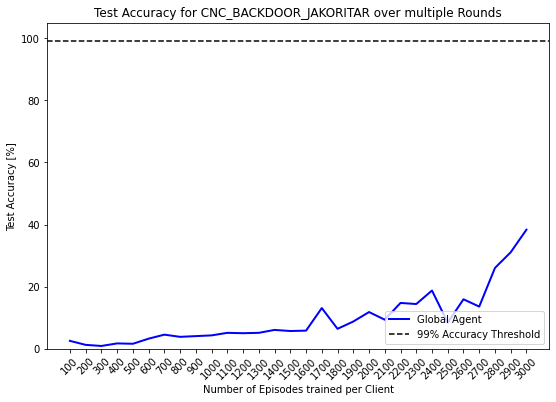

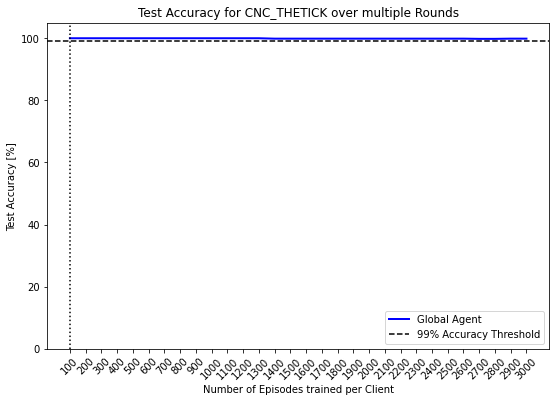

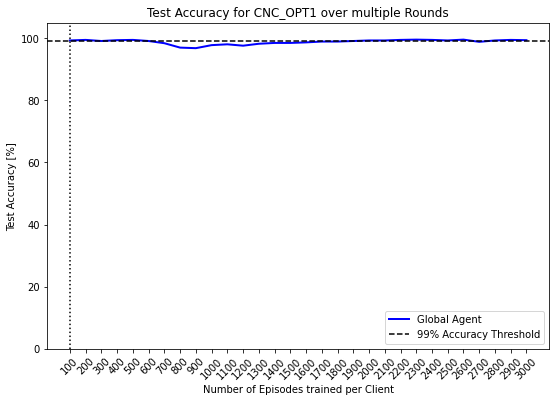

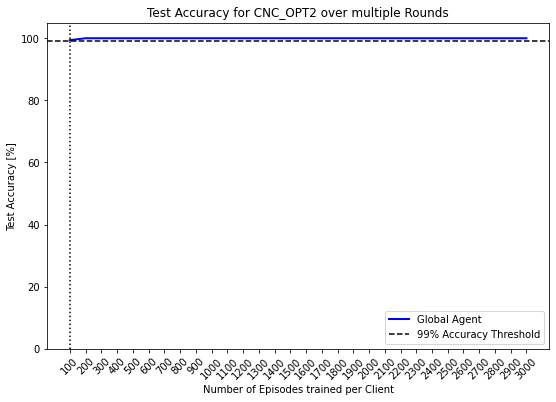

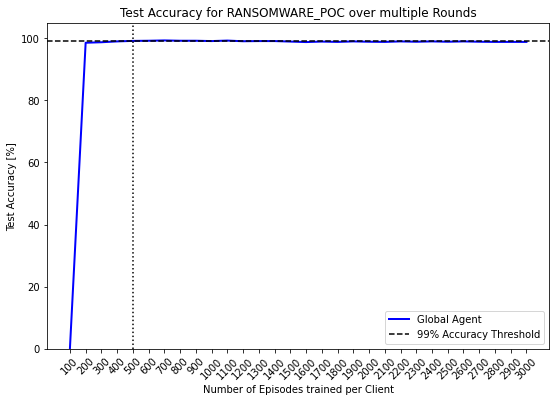

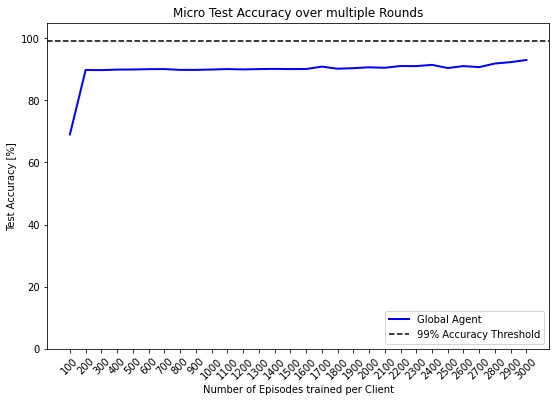

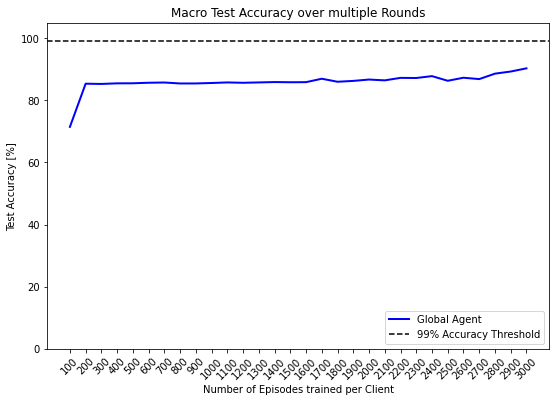

In [32]:
show_experiment_graphs(e1v6)

---
## Scenario 07 (Strong Client Exclusive Class Setting)

In [12]:
e1v7 = run_sample_distribution_experiment(1, 7, 10, training_data_strides, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02)

Dataset Balance Metrics: MID=0.0053 & WCS=0.7053
=== STARTING EXPERIMENT 1.7 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       2.52 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      98.32 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |       0.62 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.93 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |     100    | MTDTechnique.CNC_IP_SHUFFLE           |         

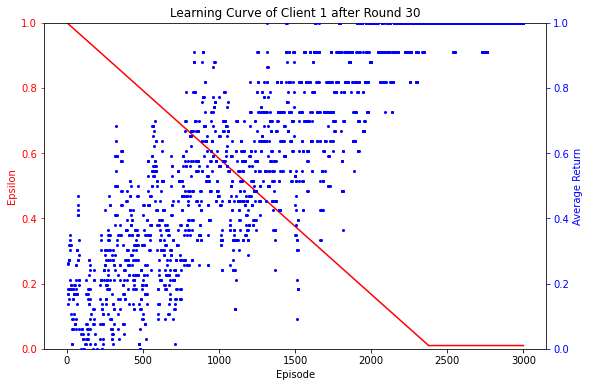

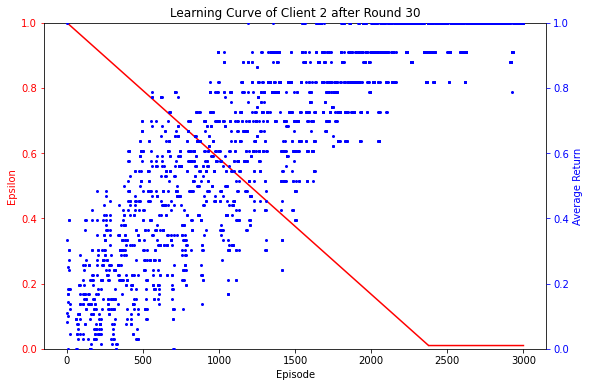

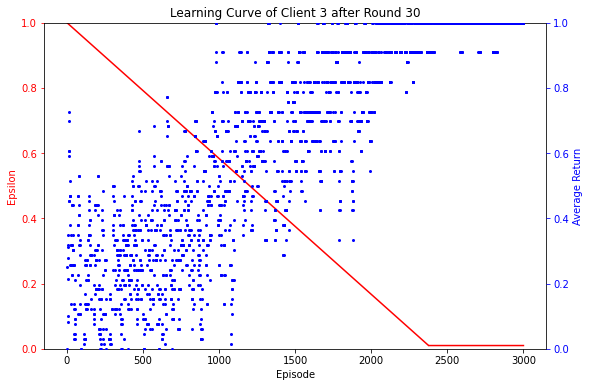

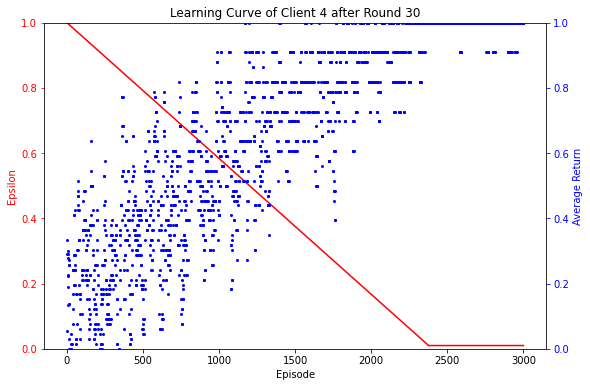

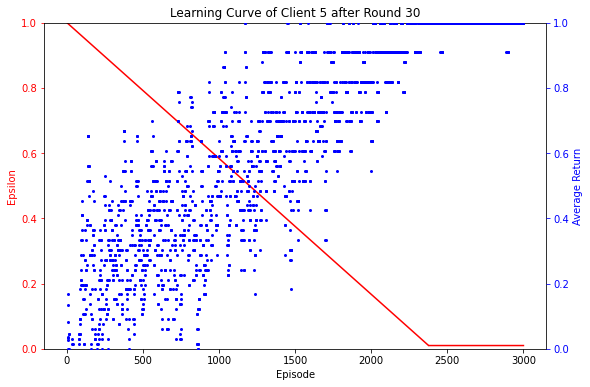

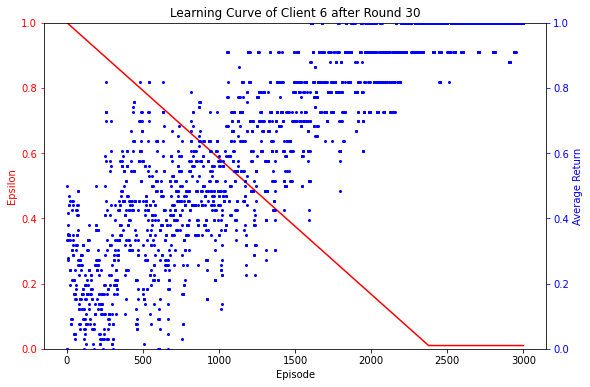

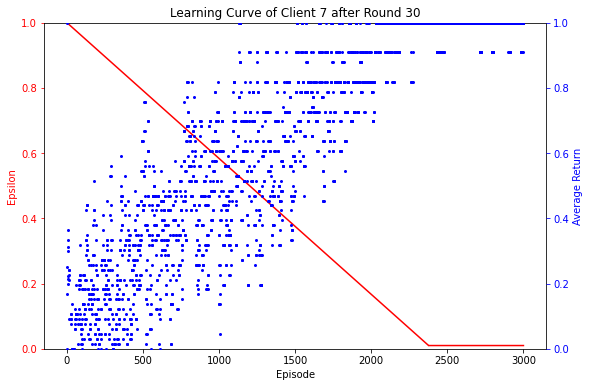

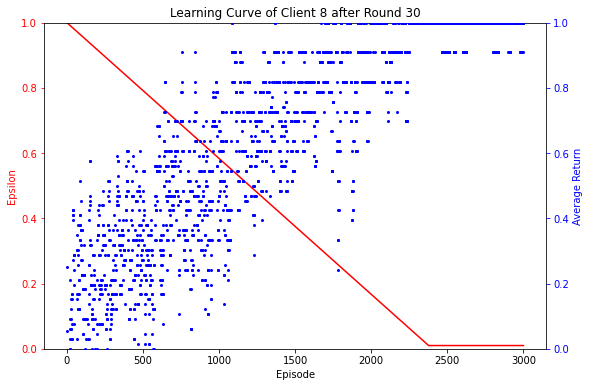

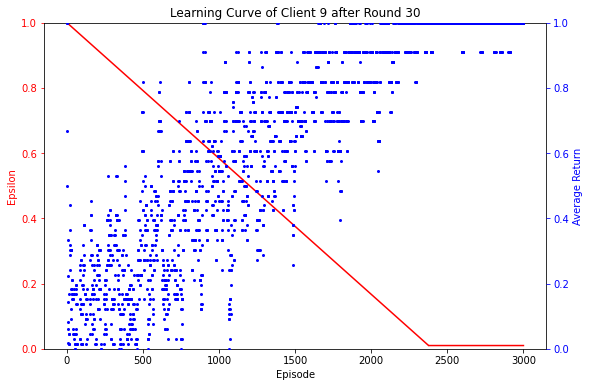

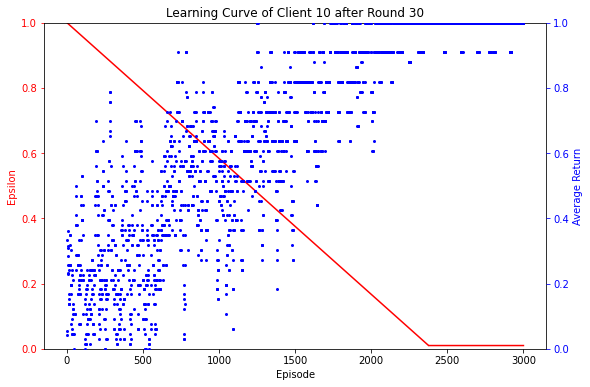

In [13]:
show_learning_curves(e1v7)

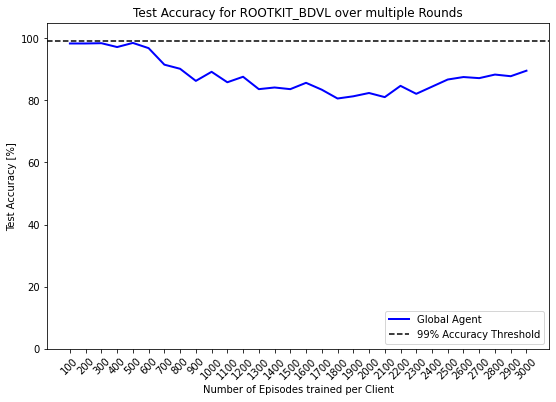

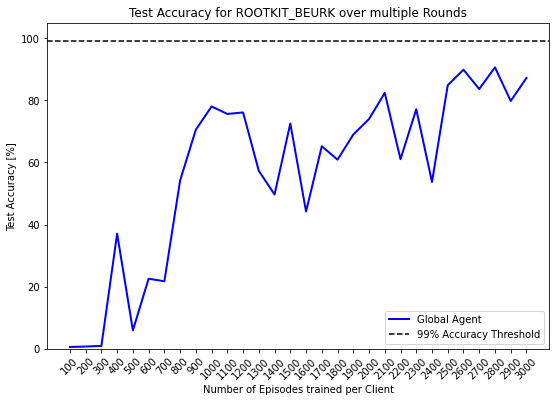

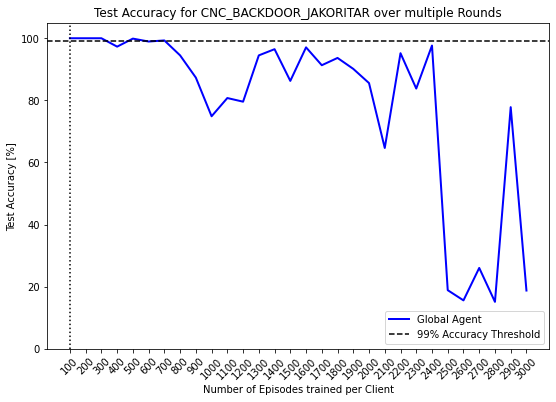

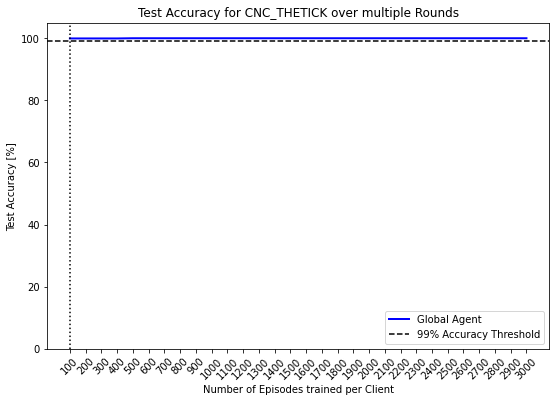

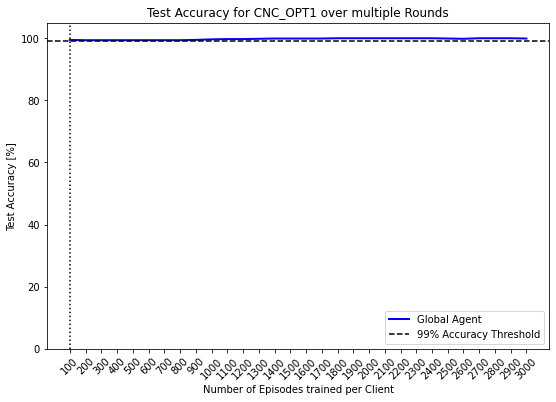

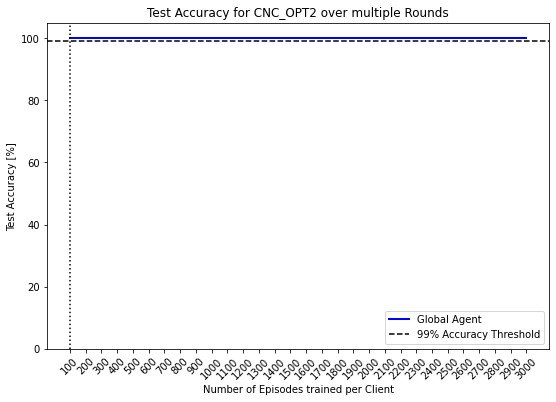

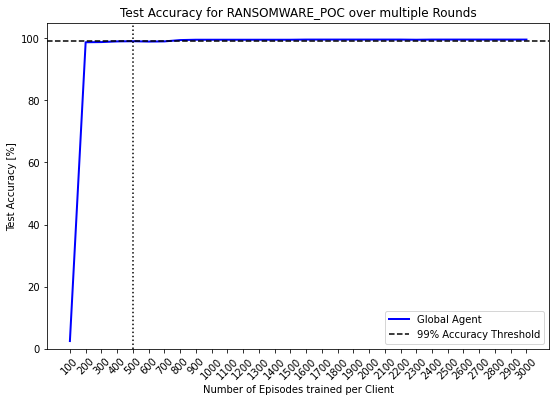

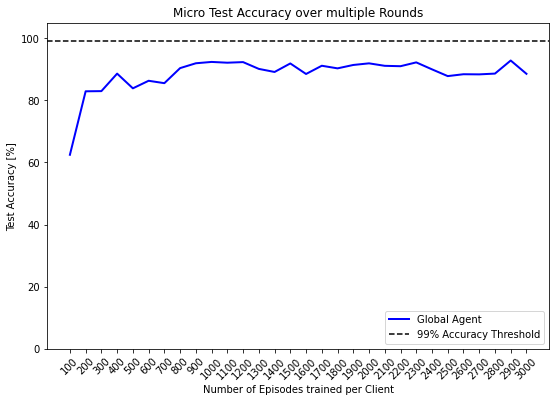

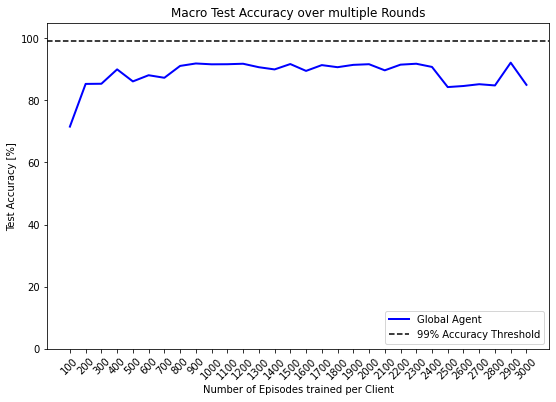

In [14]:
show_experiment_graphs(e1v7)